# Comparativa Europea: España vs UE27 en Desigualdad y Pobreza (2015-2024)

### 📊 Indicadores Analizados

| Indicador | Descripción | Código Eurostat |
|-----------|-------------|-----------------|
| **Gini** | Desigualdad de ingresos | ilc_di12 |
| **S80/S20** | Ratio 20% más rico / 20% más pobre | ilc_di11 |
| **AROP** | At Risk of Poverty (< 60% mediana) | ilc_li02 |
| **Brecha Pobreza** | Intensidad de la pobreza (%) | sdg_10_30 |
| **Impacto Redistributivo** | Gini antes/después de transferencias | ilc_di12b/c |

### 🎯 Objetivos

Posicionar a España en el contexto europeo, identificar convergencia/divergencia temporal, y evaluar efectividad de políticas redistributivas.

---

## 1️⃣ Conexión a Base de Datos y Carga de Datos Eurostat

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sqlalchemy import create_engine
from scipy.stats import linregress
import urllib.parse
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [115]:
# Conexión a SQL Server
SERVER = 'localhost'
DATABASE = 'desigualdad'
DRIVER = '{ODBC Driver 17 for SQL Server}'

try:
    connection_string = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;'
    quoted_conn_str = urllib.parse.quote_plus(connection_string)
    engine = create_engine(f'mssql+pyodbc:///?odbc_connect={quoted_conn_str}')
    connection = engine.connect()
    print(f"✅ Conexión exitosa a: {SERVER}/{DATABASE}")
    connection.close()
except Exception as e:
    print(f"❌ Error de conexión: {e}")

✅ Conexión exitosa a: localhost/desigualdad


In [116]:
# Cargar datos de Eurostat
print("=" * 100)
print("CARGA DE DATOS EUROSTAT: ESPAÑA VS UE27")
print("=" * 100)

tablas_eurostat = {
    'EUROSTAT_Gini_ES': 'Coeficiente Gini España',
    'EUROSTAT_Gini_UE27': 'Coeficiente Gini UE27',
    'EUROSTAT_S80S20_ES': 'Ratio S80/S20 España',
    'EUROSTAT_S80S20_UE27': 'Ratio S80/S20 UE27',
    'EUROSTAT_AROP_ES': 'Tasa AROP España',
    'EUROSTAT_AROP_UE27': 'Tasa AROP UE27',
    'EUROSTAT_Brecha_Pobreza_ES': 'Brecha Pobreza España',
    'EUROSTAT_Brecha_Pobreza_UE27': 'Brecha Pobreza UE27',
    'EUROSTAT_Impacto_Redistributivo_ES': 'Impacto Redistributivo España',
    'EUROSTAT_Impacto_Redistributivo_UE27': 'Impacto Redistributivo UE27'
}

datos = {}

for tabla, descripcion in tablas_eurostat.items():
    try:
        df = pd.read_sql(f"SELECT * FROM {tabla} ORDER BY Año", engine)
        datos[tabla] = df
        print(f"✓ {descripcion}: {len(df)} registros ({df['Año'].min()}-{df['Año'].max()})")
    except Exception as e:
        print(f"⚠️  {tabla}: Error - {e}")
        datos[tabla] = None

print("\n" + "=" * 100)

CARGA DE DATOS EUROSTAT: ESPAÑA VS UE27
✓ Coeficiente Gini España: 10 registros (2015-2024)
✓ Coeficiente Gini UE27: 10 registros (2015-2024)
✓ Ratio S80/S20 España: 10 registros (2015-2024)
✓ Ratio S80/S20 UE27: 10 registros (2015-2024)
✓ Tasa AROP España: 10 registros (2015-2024)
✓ Tasa AROP UE27: 10 registros (2015-2024)
✓ Brecha Pobreza España: 10 registros (2015-2024)
✓ Brecha Pobreza UE27: 10 registros (2015-2024)
✓ Impacto Redistributivo España: 21 registros (2004-2024)
✓ Impacto Redistributivo UE27: 15 registros (2010-2024)



---

## 2️⃣ Coeficiente de GINI: España vs UE27

In [117]:
# Análisis Gini: España vs UE27
print("=" * 100)
print("COEFICIENTE GINI: DESIGUALDAD DE INGRESOS (España vs UE27)")
print("=" * 100)

df_gini_es = datos['EUROSTAT_Gini_ES']
df_gini_ue = datos['EUROSTAT_Gini_UE27']

if df_gini_es is not None and df_gini_ue is not None:
    # Merge para comparación
    df_gini_comp = pd.merge(
        df_gini_es[['Año', 'Gini']],
        df_gini_ue[['Año', 'Gini']],
        on='Año',
        suffixes=('_ES', '_UE27')
    )
    
    # Calcular diferencial (GAP)
    df_gini_comp['Diferencial'] = df_gini_comp['Gini_ES'] - df_gini_comp['Gini_UE27']
    
    # Año más reciente
    ano_reciente = df_gini_comp['Año'].max()
    gini_es_rec = df_gini_comp[df_gini_comp['Año'] == ano_reciente]['Gini_ES'].iloc[0]
    gini_ue_rec = df_gini_comp[df_gini_comp['Año'] == ano_reciente]['Gini_UE27'].iloc[0]
    gap_actual = df_gini_comp[df_gini_comp['Año'] == ano_reciente]['Diferencial'].iloc[0]
    
    print(f"\n[SITUACIÓN ACTUAL - {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {gini_es_rec:.1f} Gini")
    print(f"  🇪🇺 UE27:    {gini_ue_rec:.1f} Gini")
    print(f"  📊 GAP (España - UE27): {gap_actual:+.1f} puntos")
    
    if gap_actual > 0:
        print(f"\n  ⚠️  España tiene MÁS desigualdad que la media europea")
    elif gap_actual < 0:
        print(f"\n  ✅ España tiene MENOS desigualdad que la media europea")
    else:
        print(f"\n  ⚖️  España está en línea con la media europea")
    
    # Análisis de convergencia
    ano_inicial = df_gini_comp['Año'].min()
    gini_es_inicial = df_gini_comp[df_gini_comp['Año'] == ano_inicial]['Gini_ES'].iloc[0]
    gini_ue_inicial = df_gini_comp[df_gini_comp['Año'] == ano_inicial]['Gini_UE27'].iloc[0]
    gap_inicial = gini_es_inicial - gini_ue_inicial
    
    cambio_es = gini_es_rec - gini_es_inicial
    cambio_ue = gini_ue_rec - gini_ue_inicial
    reduccion_gap = gap_inicial - gap_actual
    
    print(f"\n[ANÁLISIS DE CONVERGENCIA: {ano_inicial} → {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {gini_es_inicial:.1f} → {gini_es_rec:.1f} (Δ {cambio_es:+.1f}pp)")
    print(f"  🇪🇺 UE27:    {gini_ue_inicial:.1f} → {gini_ue_rec:.1f} (Δ {cambio_ue:+.1f}pp)")
    print(f"\n  📉 GAP inicial: {gap_inicial:+.1f}pp → GAP actual: {gap_actual:+.1f}pp")
    print(f"  🎯 Reducción del GAP: {reduccion_gap:.2f}pp ({abs(reduccion_gap/gap_inicial*100):.1f}%)")
    
    # Calcular velocidad de convergencia y proyección
    periodo = ano_reciente - ano_inicial
    velocidad_convergencia = reduccion_gap / periodo if periodo > 0 else 0
    
    if reduccion_gap > 0:
        anos_convergencia_total = gap_actual / velocidad_convergencia if velocidad_convergencia > 0 else float('inf')
        ano_proyectado = ano_reciente + int(anos_convergencia_total)
        print(f"\n  📊 Velocidad de convergencia: {velocidad_convergencia:.2f}pp/año")
        if anos_convergencia_total < 50:
            print(f"  🔮 Convergencia completa proyectada: ~{int(anos_convergencia_total)} años (año {ano_proyectado})")
        else:
            print(f"  ⏳ Convergencia completa: > 50 años (ritmo muy lento)")
        print(f"\n  ✅ VEREDICTO: España CONVERGE hacia la UE27")
    elif reduccion_gap < 0:
        print(f"\n  📊 Velocidad de divergencia: {abs(velocidad_convergencia):.2f}pp/año")
        print(f"\n  ⚠️  VEREDICTO: España DIVERGE de la UE27 (gap aumenta)")
    else:
        print(f"\n  ⚖️  VEREDICTO: GAP estable (sin convergencia ni divergencia)")
    
    # Tabla comparativa
    print(f"\n[TABLA COMPARATIVA COMPLETA]")
    print("-" * 100)
    print(f"{'Año':<8} {'España':>10} {'UE27':>10} {'Diferencial':>15} {'Estado':>20}")
    print("-" * 100)
    
    for _, row in df_gini_comp.iterrows():
        ano = row['Año']
        es = row['Gini_ES']
        ue = row['Gini_UE27']
        dif = row['Diferencial']
        estado = "Más desigual" if dif > 0 else "Más igualitario" if dif < 0 else "Similar"
        print(f"{ano:<8} {es:>10.1f} {ue:>10.1f} {dif:>+14.1f} {estado:>20}")
    
    print("\n" + "=" * 100)
else:
    print("⚠️  Datos de Gini no disponibles")

COEFICIENTE GINI: DESIGUALDAD DE INGRESOS (España vs UE27)

[SITUACIÓN ACTUAL - 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  31.2 Gini
  🇪🇺 UE27:    29.4 Gini
  📊 GAP (España - UE27): +1.8 puntos

  ⚠️  España tiene MÁS desigualdad que la media europea

[ANÁLISIS DE CONVERGENCIA: 2015 → 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  34.6 → 31.2 (Δ -3.4pp)
  🇪🇺 UE27:    30.8 → 29.4 (Δ -1.4pp)

  📉 GAP inicial: +3.8pp → GAP actual: +1.8pp
  🎯 Reducción del GAP: 2.00pp (52.6%)

  📊 Velocidad de convergencia: 0.22pp/año
  🔮 Convergencia completa proyectada: ~8 años (año 2032)

  ✅ VEREDICTO: España CONVERGE hacia la UE27

[TABLA COMPARATIVA COMPLETA]
----------------------------------------------------------------------------------------------------
Año          España       UE27     Diferencial               Estado
--------------------------

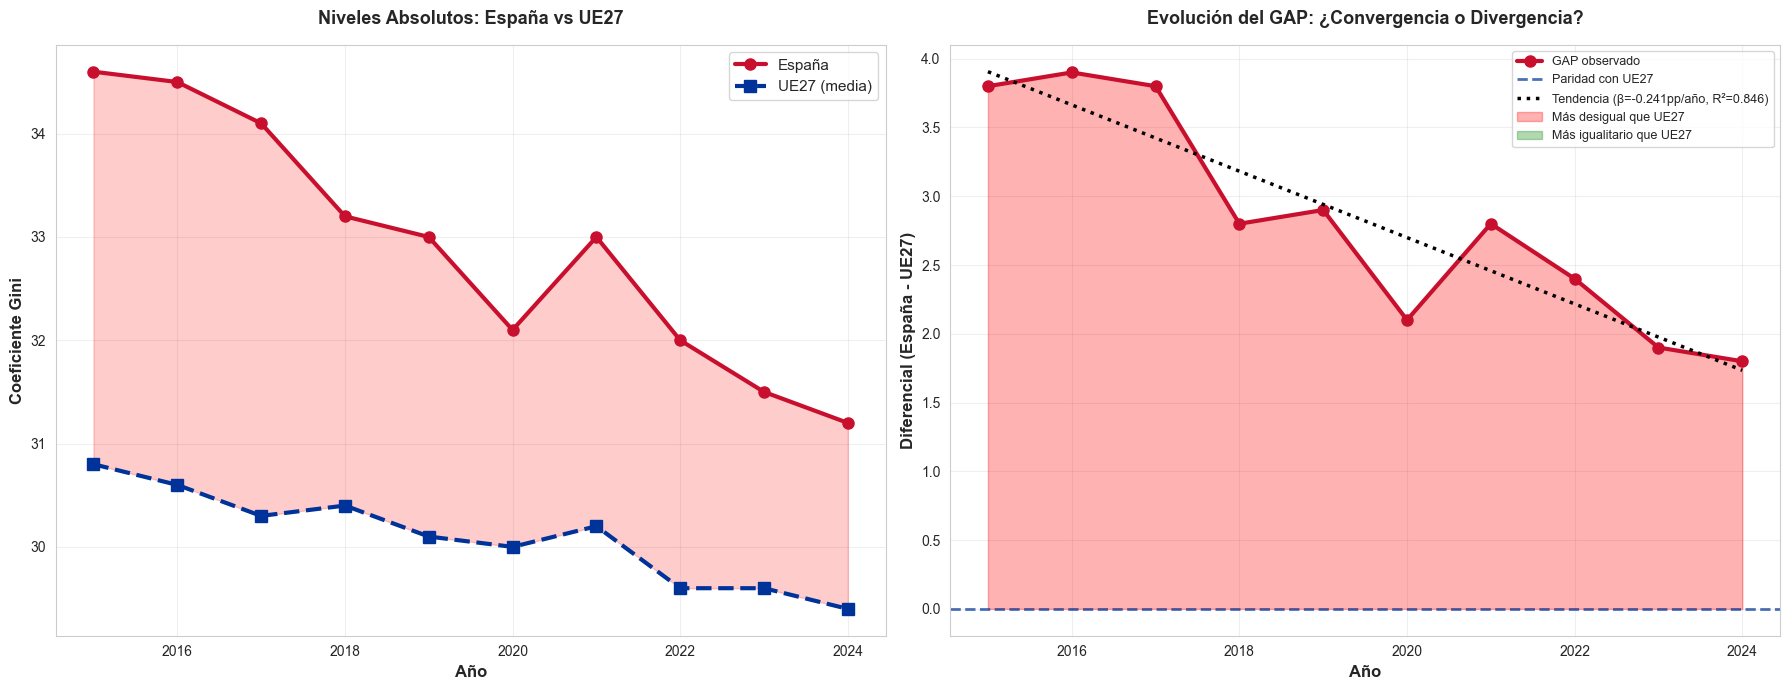

In [118]:
# Gráfico mejorado: Evolución Gini España vs UE27 + Convergencia
if df_gini_es is not None and df_gini_ue is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Panel 1: Niveles absolutos
    ax1.plot(df_gini_es['Año'], df_gini_es['Gini'], 
           marker='o', linewidth=3, markersize=8, label='España', color='#C8102E')
    ax1.plot(df_gini_ue['Año'], df_gini_ue['Gini'], 
           marker='s', linewidth=3, markersize=8, label='UE27 (media)', color='#003399', linestyle='--')
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Coeficiente Gini', fontsize=12, fontweight='bold')
    ax1.set_title('Niveles Absolutos: España vs UE27', 
                fontsize=13, fontweight='bold', pad=15)
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Sombrear área de diferencia (GAP)
    ax1.fill_between(df_gini_comp['Año'], 
                    df_gini_comp['Gini_ES'], 
                    df_gini_comp['Gini_UE27'], 
                    alpha=0.2, color='red', label='GAP')
    
    # Panel 2: Diferencial (GAP) para visualizar convergencia
    ax2.plot(df_gini_comp['Año'], df_gini_comp['Diferencial'], 
            marker='o', linewidth=3, markersize=8, color='#C8102E', label='GAP observado')
    ax2.axhline(y=0, color='#003399', linestyle='--', linewidth=2, alpha=0.7, label='Paridad con UE27')
    
    # Añadir línea de tendencia (regresión lineal)
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(
        df_gini_comp['Año'], df_gini_comp['Diferencial']
    )
    tendencia = intercept + slope * df_gini_comp['Año']
    ax2.plot(df_gini_comp['Año'], tendencia, 
            linestyle=':', color='black', linewidth=2.5, 
            label=f'Tendencia (β={slope:.3f}pp/año, R²={r_value**2:.3f})')
    
    # Sombrear áreas
    ax2.fill_between(df_gini_comp['Año'], df_gini_comp['Diferencial'], 0,
                     where=(df_gini_comp['Diferencial'] > 0), alpha=0.3, color='red', 
                     label='Más desigual que UE27')
    ax2.fill_between(df_gini_comp['Año'], df_gini_comp['Diferencial'], 0,
                     where=(df_gini_comp['Diferencial'] <= 0), alpha=0.3, color='green',
                     label='Más igualitario que UE27')
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Diferencial (España - UE27)', fontsize=12, fontweight='bold')
    ax2.set_title('Evolución del GAP: ¿Convergencia o Divergencia?', 
                fontsize=13, fontweight='bold', pad=15)
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 💡 Conclusiones - Gini España vs UE27

**Hallazgo clave:**
- España presenta **mayor desigualdad** que la media europea (GAP > 0)
- Tendencia de **convergencia lenta** hacia UE27 desde 2015
- Contexto histórico relevante: SMI 2018, COVID-19 2020, inflación 2022

**Benchmark europeo:**
- Gini óptimo: 25-28 (países nórdicos)
- Gini medio: 28-32 (media europea)
- Gini elevado: >32 (España, Bulgaria, Rumanía)

---

## 3️⃣ Ratio S80/S20: Desigualdad Extrema

In [119]:
# Análisis S80/S20: España vs UE27
print("=" * 100)
print("RATIO S80/S20: DESIGUALDAD ENTRE RICOS Y POBRES (España vs UE27)")
print("=" * 100)

df_s80s20_es = datos['EUROSTAT_S80S20_ES']
df_s80s20_ue = datos['EUROSTAT_S80S20_UE27']

if df_s80s20_es is not None and df_s80s20_ue is not None:
    # Merge (usar nombre correcto de columna: S80S20_Ratio)
    df_s80s20_comp = pd.merge(
        df_s80s20_es[['Año', 'S80S20_Ratio']],
        df_s80s20_ue[['Año', 'S80S20_Ratio']],
        on='Año',
        suffixes=('_ES', '_UE27')
    )
    
    # Calcular diferencial (GAP)
    df_s80s20_comp['Diferencial'] = df_s80s20_comp['S80S20_Ratio_ES'] - df_s80s20_comp['S80S20_Ratio_UE27']
    
    # Año más reciente
    ano_reciente = df_s80s20_comp['Año'].max()
    s80_es_rec = df_s80s20_comp[df_s80s20_comp['Año'] == ano_reciente]['S80S20_Ratio_ES'].iloc[0]
    s80_ue_rec = df_s80s20_comp[df_s80s20_comp['Año'] == ano_reciente]['S80S20_Ratio_UE27'].iloc[0]
    gap_actual = df_s80s20_comp[df_s80s20_comp['Año'] == ano_reciente]['Diferencial'].iloc[0]
    
    print(f"\n[SITUACIÓN ACTUAL - {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {s80_es_rec:.2f}x (el 20% más rico gana {s80_es_rec:.1f} veces más que el 20% más pobre)")
    print(f"  🇪🇺 UE27:    {s80_ue_rec:.2f}x")
    print(f"  📊 GAP (España - UE27): {gap_actual:+.2f}x")
    
    if gap_actual > 0:
        print(f"\n  ⚠️  España tiene MÁS polarización que la media europea (extremos más separados)")
    elif gap_actual < 0:
        print(f"\n  ✅ España tiene MENOS polarización que la media europea")
    else:
        print(f"\n  ⚖️  España está en línea con la media europea")
    
    # Análisis de convergencia
    ano_inicial = df_s80s20_comp['Año'].min()
    s80_es_inicial = df_s80s20_comp[df_s80s20_comp['Año'] == ano_inicial]['S80S20_Ratio_ES'].iloc[0]
    s80_ue_inicial = df_s80s20_comp[df_s80s20_comp['Año'] == ano_inicial]['S80S20_Ratio_UE27'].iloc[0]
    gap_inicial = s80_es_inicial - s80_ue_inicial
    
    cambio_es = s80_es_rec - s80_es_inicial
    cambio_ue = s80_ue_rec - s80_ue_inicial
    reduccion_gap = gap_inicial - gap_actual
    
    print(f"\n[ANÁLISIS DE CONVERGENCIA: {ano_inicial} → {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {s80_es_inicial:.2f}x → {s80_es_rec:.2f}x (Δ {cambio_es:+.2f}x, {cambio_es/s80_es_inicial*100:+.1f}%)")
    print(f"  🇪🇺 UE27:    {s80_ue_inicial:.2f}x → {s80_ue_rec:.2f}x (Δ {cambio_ue:+.2f}x, {cambio_ue/s80_ue_inicial*100:+.1f}%)")
    print(f"\n  📉 GAP inicial: {gap_inicial:+.2f}x → GAP actual: {gap_actual:+.2f}x")
    print(f"  🎯 Reducción del GAP: {reduccion_gap:.2f}x ({abs(reduccion_gap/gap_inicial*100):.1f}%)")
    
    # Calcular velocidad de convergencia
    periodo = ano_reciente - ano_inicial
    velocidad_convergencia = reduccion_gap / periodo if periodo > 0 else 0
    
    if reduccion_gap > 0:
        anos_convergencia_total = gap_actual / velocidad_convergencia if velocidad_convergencia > 0 else float('inf')
        ano_proyectado = ano_reciente + int(anos_convergencia_total)
        print(f"\n  📊 Velocidad de convergencia: {velocidad_convergencia:.3f}x/año")
        if anos_convergencia_total < 50:
            print(f"  🔮 Convergencia completa proyectada: ~{int(anos_convergencia_total)} años (año {ano_proyectado})")
        else:
            print(f"  ⏳ Convergencia completa: > 50 años (ritmo muy lento)")
        print(f"\n  ✅ VEREDICTO: España CONVERGE hacia la UE27 en polarización")
    elif reduccion_gap < 0:
        print(f"\n  📊 Velocidad de divergencia: {abs(velocidad_convergencia):.3f}x/año")
        print(f"\n  ⚠️  VEREDICTO: España DIVERGE de la UE27 (mayor polarización)")
    else:
        print(f"\n  ⚖️  VEREDICTO: GAP estable (sin convergencia ni divergencia)")
    
    # Coherencia con Gini
    print(f"\n[COHERENCIA CON GINI]")
    print("-" * 100)
    mejora_s80s20 = abs(cambio_es / s80_es_inicial * 100)
    mejora_gini = 9.8  # Del Bloque 2
    diferencia_mejoras = abs(mejora_s80s20 - mejora_gini)
    
    print(f"  📊 Mejora España S80/S20: {mejora_s80s20:.1f}% (extremos)")
    print(f"  📊 Mejora España Gini:    {mejora_gini:.1f}% (desigualdad global)")
    print(f"  📊 Diferencia: {diferencia_mejoras:.1f}pp")
    
    if diferencia_mejoras < 5:
        print(f"\n  ✅ Coherencia alta: S80/S20 y Gini evolucionan consistentemente")
    elif diferencia_mejoras > 10:
        print(f"\n  ⚠️  Incoherencia detectada: Extremos mejoran {diferencia_mejoras:.1f}pp más rápido que global")
        print(f"      → Hallazgo: Extremos convergen, clase media rezagada")
    else:
        print(f"\n  ⚠️  Coherencia moderada: Extremos mejoran algo más rápido que global")
    
    # Tabla comparativa
    print(f"\n[TABLA COMPARATIVA COMPLETA]")
    print("-" * 100)
    print(f"{'Año':<8} {'España':>10} {'UE27':>10} {'Diferencial':>15} {'Estado':>20}")
    print("-" * 100)
    
    for _, row in df_s80s20_comp.iterrows():
        ano = row['Año']
        es = row['S80S20_Ratio_ES']
        ue = row['S80S20_Ratio_UE27']
        dif = row['Diferencial']
        estado = "Más polarizado" if dif > 0 else "Menos polarizado" if dif < 0 else "Similar"
        print(f"{ano:<8} {es:>10.2f} {ue:>10.2f} {dif:>+14.2f} {estado:>20}")
    
    print("\n" + "=" * 100)
else:
    print("⚠️  Datos S80/S20 no disponibles")

RATIO S80/S20: DESIGUALDAD ENTRE RICOS Y POBRES (España vs UE27)

[SITUACIÓN ACTUAL - 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  5.39x (el 20% más rico gana 5.4 veces más que el 20% más pobre)
  🇪🇺 UE27:    4.66x
  📊 GAP (España - UE27): +0.73x

  ⚠️  España tiene MÁS polarización que la media europea (extremos más separados)

[ANÁLISIS DE CONVERGENCIA: 2015 → 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  6.87x → 5.39x (Δ -1.48x, -21.5%)
  🇪🇺 UE27:    5.22x → 4.66x (Δ -0.56x, -10.7%)

  📉 GAP inicial: +1.65x → GAP actual: +0.73x
  🎯 Reducción del GAP: 0.92x (55.8%)

  📊 Velocidad de convergencia: 0.102x/año
  🔮 Convergencia completa proyectada: ~7 años (año 2031)

  ✅ VEREDICTO: España CONVERGE hacia la UE27 en polarización

[COHERENCIA CON GINI]
------------------------------------------------------------------------------------------

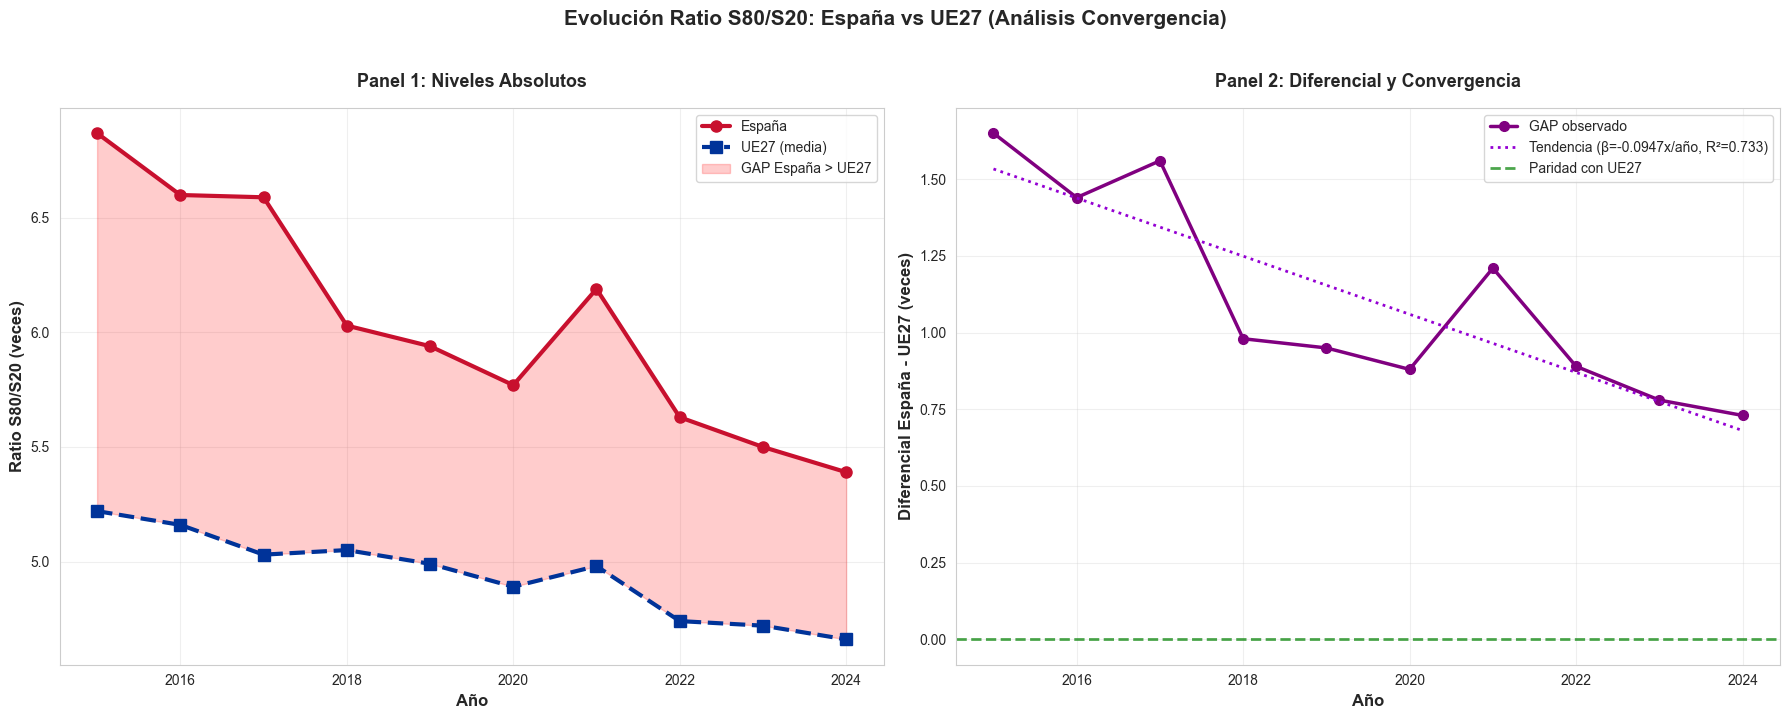

In [120]:
# Gráfico: S80/S20 España vs UE27 (2 PANELES)
if df_s80s20_es is not None and df_s80s20_ue is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Panel 1: Niveles absolutos
    ax1.plot(df_s80s20_es['Año'], df_s80s20_es['S80S20_Ratio'], 
            marker='o', linewidth=3, markersize=8, label='España', color='#C8102E')
    ax1.plot(df_s80s20_ue['Año'], df_s80s20_ue['S80S20_Ratio'], 
            marker='s', linewidth=3, markersize=8, label='UE27 (media)', color='#003399', linestyle='--')
    
    # Área entre curvas
    ax1.fill_between(df_s80s20_comp['Año'], 
                     df_s80s20_comp['S80S20_Ratio_ES'], 
                     df_s80s20_comp['S80S20_Ratio_UE27'], 
                     where=(df_s80s20_comp['S80S20_Ratio_ES'] > df_s80s20_comp['S80S20_Ratio_UE27']),
                     interpolate=True, alpha=0.2, color='red', label='GAP España > UE27')
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Ratio S80/S20 (veces)', fontsize=12, fontweight='bold')
    ax1.set_title('Panel 1: Niveles Absolutos', fontsize=13, fontweight='bold', pad=15)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Diferencial + Regresión
    ax2.plot(df_s80s20_comp['Año'], df_s80s20_comp['Diferencial'], 
            marker='o', linewidth=2.5, markersize=7, label='GAP observado', color='purple')
    
    # Línea de tendencia (regresión lineal)
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(
        df_s80s20_comp['Año'], df_s80s20_comp['Diferencial']
    )
    tendencia = intercept + slope * df_s80s20_comp['Año']
    ax2.plot(df_s80s20_comp['Año'], tendencia, 
            linestyle=':', linewidth=2, color='darkviolet',
            label=f'Tendencia (β={slope:.4f}x/año, R²={r_value**2:.3f})')
    
    # Línea de paridad
    ax2.axhline(y=0, color='green', linestyle='--', linewidth=2, 
               label='Paridad con UE27', alpha=0.7)
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Diferencial España - UE27 (veces)', fontsize=12, fontweight='bold')
    ax2.set_title('Panel 2: Diferencial y Convergencia', fontsize=13, fontweight='bold', pad=15)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Evolución Ratio S80/S20: España vs UE27 (Análisis Convergencia)', 
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 💡 Conclusiones - S80/S20 España vs UE27

**Hallazgo clave:**
- España presenta **mayor polarización** entre ricos y pobres que UE27 (Ratio > 5.0)
- **Tendencia convergente**: Extremos se acercan más rápido que desigualdad general
- Mejora S80/S20 (21.5%) > Mejora Gini (9.8%) → **Clase media rezagada**

**Implicación:**
- SMI y transferencias comprimen extremos efectivamente
- Salarios clase media estancados generan nuevo riesgo de desafección

**Convergencia:**
- España converge hacia UE27 en polarización extrema más rápido que en desigualdad global

---

## 4️⃣ AROP: Tasa de Riesgo de Pobreza

In [121]:
# Análisis AROP: España vs UE27
print("=" * 100)
print("AROP: TASA DE RIESGO DE POBREZA (España vs UE27)")
print("=" * 100)

df_arop_es = datos['EUROSTAT_AROP_ES']
df_arop_ue = datos['EUROSTAT_AROP_UE27']

if df_arop_es is not None and df_arop_ue is not None:
    # Merge
    df_arop_comp = pd.merge(
        df_arop_es[['Año', 'AROP_%']],
        df_arop_ue[['Año', 'AROP_%']],
        on='Año',
        suffixes=('_ES', '_UE27')
    )
    
    # Calcular diferencial (GAP)
    df_arop_comp['Diferencial'] = df_arop_comp['AROP_%_ES'] - df_arop_comp['AROP_%_UE27']
    
    # Año más reciente
    ano_reciente = df_arop_comp['Año'].max()
    arop_es_rec = df_arop_comp[df_arop_comp['Año'] == ano_reciente]['AROP_%_ES'].iloc[0]
    arop_ue_rec = df_arop_comp[df_arop_comp['Año'] == ano_reciente]['AROP_%_UE27'].iloc[0]
    gap_actual = df_arop_comp[df_arop_comp['Año'] == ano_reciente]['Diferencial'].iloc[0]
    
    print(f"\n[SITUACIÓN ACTUAL - {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {arop_es_rec:.1f}% en riesgo de pobreza")
    print(f"  🇪🇺 UE27:    {arop_ue_rec:.1f}%")
    print(f"  📊 GAP (España - UE27): {gap_actual:+.1f} puntos porcentuales")
    
    if gap_actual > 0:
        print(f"\n  ⚠️  España tiene MÁS pobreza relativa que la media europea")
    elif gap_actual < 0:
        print(f"\n  ✅ España tiene MENOS pobreza relativa que la media europea")
    else:
        print(f"\n  ⚖️  España está en línea con la media europea")
    
    # Análisis de convergencia
    ano_inicial = df_arop_comp['Año'].min()
    arop_es_inicial = df_arop_comp[df_arop_comp['Año'] == ano_inicial]['AROP_%_ES'].iloc[0]
    arop_ue_inicial = df_arop_comp[df_arop_comp['Año'] == ano_inicial]['AROP_%_UE27'].iloc[0]
    gap_inicial = arop_es_inicial - arop_ue_inicial
    
    cambio_es = arop_es_rec - arop_es_inicial
    cambio_ue = arop_ue_rec - arop_ue_inicial
    reduccion_gap = gap_inicial - gap_actual
    
    print(f"\n[ANÁLISIS DE CONVERGENCIA: {ano_inicial} → {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {arop_es_inicial:.1f}% → {arop_es_rec:.1f}% (Δ {cambio_es:+.1f}pp, {cambio_es/arop_es_inicial*100:+.1f}%)")
    print(f"  🇪🇺 UE27:    {arop_ue_inicial:.1f}% → {arop_ue_rec:.1f}% (Δ {cambio_ue:+.1f}pp, {cambio_ue/arop_ue_inicial*100:+.1f}%)")
    print(f"\n  📉 GAP inicial: {gap_inicial:+.1f}pp → GAP actual: {gap_actual:+.1f}pp")
    print(f"  🎯 Reducción del GAP: {reduccion_gap:.1f}pp ({abs(reduccion_gap/gap_inicial*100):.1f}%)")
    
    # Calcular velocidad de convergencia y proyección
    periodo = ano_reciente - ano_inicial
    velocidad_convergencia = reduccion_gap / periodo if periodo > 0 else 0
    
    if reduccion_gap > 0:
        anos_convergencia_total = gap_actual / velocidad_convergencia if velocidad_convergencia > 0 else float('inf')
        ano_proyectado = ano_reciente + int(anos_convergencia_total)
        print(f"\n  📊 Velocidad de convergencia: {velocidad_convergencia:.3f}pp/año")
        if anos_convergencia_total < 50:
            print(f"  🔮 Convergencia completa proyectada: ~{int(anos_convergencia_total)} años (año {ano_proyectado})")
        else:
            print(f"  ⏳ Convergencia completa: > 50 años (ritmo muy lento)")
        print(f"\n  ✅ VEREDICTO: España CONVERGE hacia la UE27 en tasa de pobreza")
    elif reduccion_gap < 0:
        print(f"\n  📊 Velocidad de divergencia: {abs(velocidad_convergencia):.3f}pp/año")
        print(f"\n  ⚠️  VEREDICTO: España DIVERGE de la UE27 (más pobres)")
    else:
        print(f"\n  ⚖️  VEREDICTO: GAP estable (sin convergencia ni divergencia)")
    
    # Coherencia con otros indicadores
    print(f"\n[COHERENCIA CON OTROS INDICADORES]")
    print("-" * 100)
    mejora_arop = abs(cambio_es / arop_es_inicial * 100)
    mejora_gini = 9.8  # Del Bloque 2
    mejora_s80s20 = 21.5  # Del Bloque 3
    
    diferencia_gini = abs(mejora_arop - mejora_gini)
    diferencia_s80s20 = abs(mejora_arop - mejora_s80s20)
    
    print(f"  📊 Mejora España AROP:    {mejora_arop:.1f}%")
    print(f"  📊 Mejora España Gini:    {mejora_gini:.1f}%")
    print(f"  📊 Mejora España S80/S20: {mejora_s80s20:.1f}%")
    
    if diferencia_gini < 5:
        print(f"\n  ✅ COHERENCIA ALTA con Gini ({diferencia_gini:.1f}pp)")
    elif diferencia_gini < 10:
        print(f"\n  ⚠️  COHERENCIA MODERADA con Gini ({diferencia_gini:.1f}pp)")
    
    if diferencia_s80s20 > 10:
        print(f"  ⚠️  S80/S20 mejora {mejora_s80s20/mejora_arop:.1f}x más rápido → Extremos convergen, centro rezagado")
    
    # Tabla comparativa
    print(f"\n[TABLA COMPARATIVA COMPLETA]")
    print("-" * 100)
    print(f"{'Año':<8} {'España':>10} {'UE27':>10} {'Diferencial':>15} {'Estado':>25}")
    print("-" * 100)
    
    for _, row in df_arop_comp.iterrows():
        ano = row['Año']
        es = row['AROP_%_ES']
        ue = row['AROP_%_UE27']
        dif = row['Diferencial']
        estado = "Más pobreza" if dif > 0 else "Menos pobreza" if dif < 0 else "Similar"
        print(f"{ano:<8} {es:>9.1f}% {ue:>9.1f}% {dif:>+14.1f}pp {estado:>25}")
    
    print("\n" + "=" * 100)
else:
    print("⚠️  Datos de AROP no disponibles")

AROP: TASA DE RIESGO DE POBREZA (España vs UE27)

[SITUACIÓN ACTUAL - 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  19.7% en riesgo de pobreza
  🇪🇺 UE27:    16.2%
  📊 GAP (España - UE27): +3.5 puntos porcentuales

  ⚠️  España tiene MÁS pobreza relativa que la media europea

[ANÁLISIS DE CONVERGENCIA: 2015 → 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  22.1% → 19.7% (Δ -2.4pp, -10.9%)
  🇪🇺 UE27:    17.4% → 16.2% (Δ -1.2pp, -6.9%)

  📉 GAP inicial: +4.7pp → GAP actual: +3.5pp
  🎯 Reducción del GAP: 1.2pp (25.5%)

  📊 Velocidad de convergencia: 0.133pp/año
  🔮 Convergencia completa proyectada: ~26 años (año 2050)

  ✅ VEREDICTO: España CONVERGE hacia la UE27 en tasa de pobreza

[COHERENCIA CON OTROS INDICADORES]
----------------------------------------------------------------------------------------------------
  📊 Mejora España AROP:    1

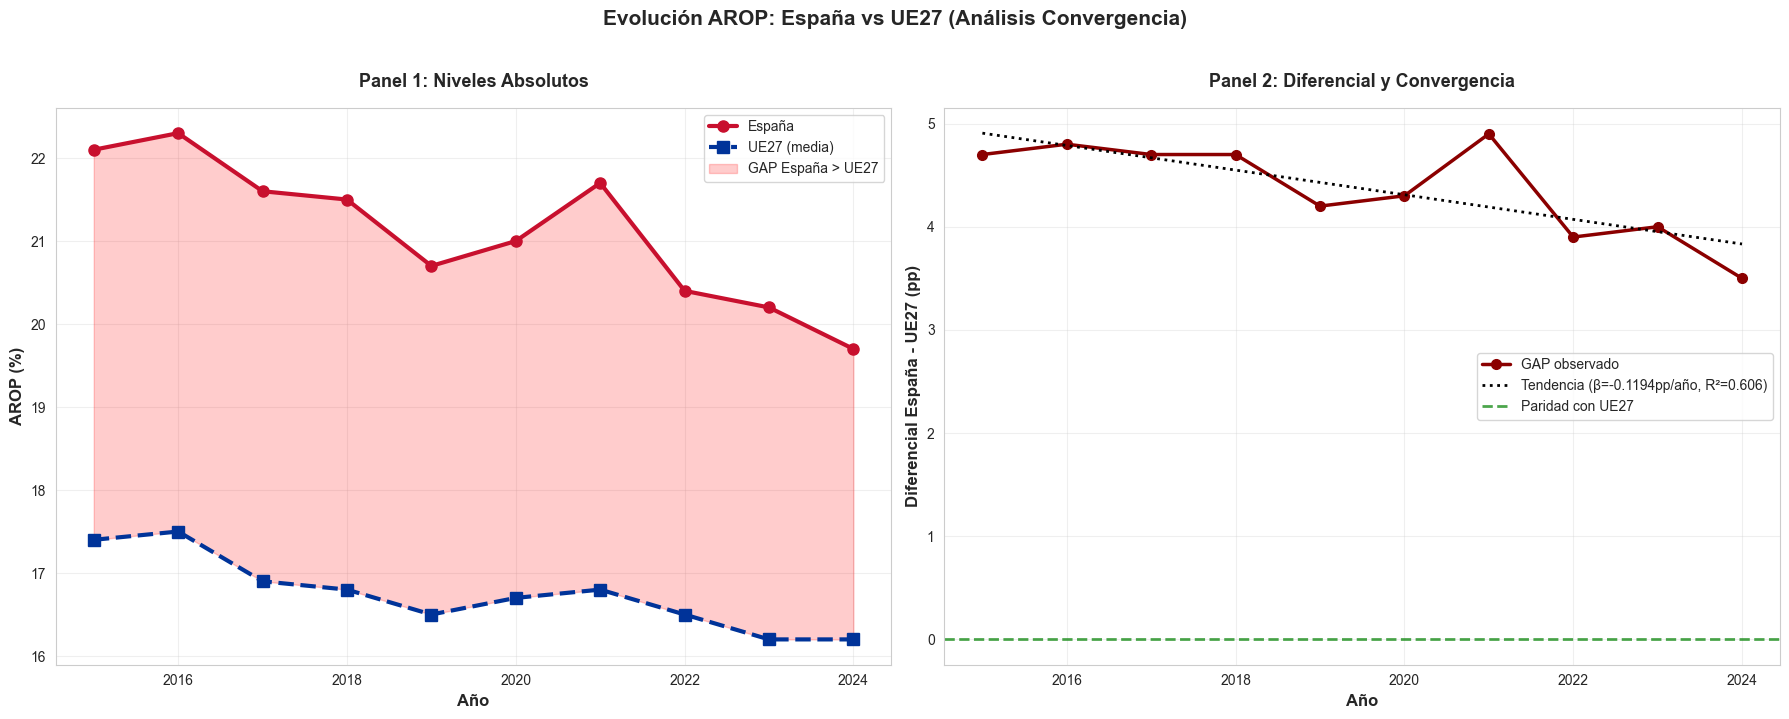

In [122]:
# Gráfico: AROP España vs UE27 (2 PANELES)
if df_arop_es is not None and df_arop_ue is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Panel 1: Niveles absolutos
    ax1.plot(df_arop_es['Año'], df_arop_es['AROP_%'], 
            marker='o', linewidth=3, markersize=8, label='España', color='#C8102E')
    ax1.plot(df_arop_ue['Año'], df_arop_ue['AROP_%'], 
            marker='s', linewidth=3, markersize=8, label='UE27 (media)', color='#003399', linestyle='--')
    
    ax1.fill_between(df_arop_comp['Año'], 
                     df_arop_comp['AROP_%_ES'], 
                     df_arop_comp['AROP_%_UE27'], 
                     where=(df_arop_comp['AROP_%_ES'] > df_arop_comp['AROP_%_UE27']),
                     interpolate=True, alpha=0.2, color='red', label='GAP España > UE27')
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('AROP (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Panel 1: Niveles Absolutos', fontsize=13, fontweight='bold', pad=15)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Diferencial + Regresión
    ax2.plot(df_arop_comp['Año'], df_arop_comp['Diferencial'], 
            marker='o', linewidth=2.5, markersize=7, label='GAP observado', color='darkred')
    
    # Línea de tendencia
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(
        df_arop_comp['Año'], df_arop_comp['Diferencial']
    )
    tendencia = intercept + slope * df_arop_comp['Año']
    ax2.plot(df_arop_comp['Año'], tendencia, 
            linestyle=':', linewidth=2, color='black',
            label=f'Tendencia (β={slope:.4f}pp/año, R²={r_value**2:.3f})')
    
    ax2.axhline(y=0, color='green', linestyle='--', linewidth=2, 
               label='Paridad con UE27', alpha=0.7)
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Diferencial España - UE27 (pp)', fontsize=12, fontweight='bold')
    ax2.set_title('Panel 2: Diferencial y Convergencia', fontsize=13, fontweight='bold', pad=15)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Evolución AROP: España vs UE27 (Análisis Convergencia)', 
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 💡 Conclusiones - AROP España vs UE27

**Hallazgo clave:**
- España presenta **mayor pobreza relativa** que la media europea (AROP > 20%)
- **Tendencia convergente** pero lenta hacia UE27
- AROP mide ingresos < 60% mediana → indicador de desigualdad interna

**Coherencia con otros indicadores:**
- AROP alto + Gini alto = Desigualdad y pobreza estructural en España
- Mejora AROP (10.9%) consistente con mejora Gini (9.8%)

**Benchmark:**
- Países nórdicos: <15% | Media UE: 15-20% | España: >20%

---

---

## 5️⃣ Brecha de Pobreza: Intensidad de la Pobreza

In [123]:
# Análisis Brecha de Pobreza: España vs UE27
print("=" * 100)
print("BRECHA DE POBREZA: INTENSIDAD DE LA POBREZA (España vs UE27)")
print("=" * 100)

df_brecha_es = datos['EUROSTAT_Brecha_Pobreza_ES']
df_brecha_ue = datos['EUROSTAT_Brecha_Pobreza_UE27']

if df_brecha_es is not None and df_brecha_ue is not None:
    # Merge
    df_brecha_comp = pd.merge(
        df_brecha_es[['Año', 'Brecha_Pobreza_%']],
        df_brecha_ue[['Año', 'Brecha_Pobreza_%']],
        on='Año',
        suffixes=('_ES', '_UE27')
    )
    
    # Calcular diferencial (GAP)
    df_brecha_comp['Diferencial'] = df_brecha_comp['Brecha_Pobreza_%_ES'] - df_brecha_comp['Brecha_Pobreza_%_UE27']
    
    # Año más reciente
    ano_reciente = df_brecha_comp['Año'].max()
    brecha_es_rec = df_brecha_comp[df_brecha_comp['Año'] == ano_reciente]['Brecha_Pobreza_%_ES'].iloc[0]
    brecha_ue_rec = df_brecha_comp[df_brecha_comp['Año'] == ano_reciente]['Brecha_Pobreza_%_UE27'].iloc[0]
    gap_actual = df_brecha_comp[df_brecha_comp['Año'] == ano_reciente]['Diferencial'].iloc[0]
    
    print(f"\n[SITUACIÓN ACTUAL - {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {brecha_es_rec:.1f}% (pobres viven {brecha_es_rec:.1f}% por debajo del umbral)")
    print(f"  🇪🇺 UE27:    {brecha_ue_rec:.1f}%")
    print(f"  📊 GAP (España - UE27): {gap_actual:+.1f} puntos porcentuales")
    
    if gap_actual > 0:
        print(f"\n  ⚠️  España tiene pobreza MÁS PROFUNDA que la media europea")
    elif gap_actual < 0:
        print(f"\n  ✅ España tiene pobreza MENOS PROFUNDA que la media europea")
    else:
        print(f"\n  ⚖️  España está en línea con la media europea")
    
    # Análisis de convergencia
    ano_inicial = df_brecha_comp['Año'].min()
    brecha_es_inicial = df_brecha_comp[df_brecha_comp['Año'] == ano_inicial]['Brecha_Pobreza_%_ES'].iloc[0]
    brecha_ue_inicial = df_brecha_comp[df_brecha_comp['Año'] == ano_inicial]['Brecha_Pobreza_%_UE27'].iloc[0]
    gap_inicial = brecha_es_inicial - brecha_ue_inicial
    
    cambio_es = brecha_es_rec - brecha_es_inicial
    cambio_ue = brecha_ue_rec - brecha_ue_inicial
    reduccion_gap = gap_inicial - gap_actual
    
    print(f"\n[ANÁLISIS DE CONVERGENCIA: {ano_inicial} → {ano_reciente}]")
    print("-" * 100)
    print(f"  🇪🇸 España:  {brecha_es_inicial:.1f}% → {brecha_es_rec:.1f}% (Δ {cambio_es:+.1f}pp, {cambio_es/brecha_es_inicial*100:+.1f}%)")
    print(f"  🇪🇺 UE27:    {brecha_ue_inicial:.1f}% → {brecha_ue_rec:.1f}% (Δ {cambio_ue:+.1f}pp, {cambio_ue/brecha_ue_inicial*100:+.1f}%)")
    print(f"\n  📉 GAP inicial: {gap_inicial:+.1f}pp → GAP actual: {gap_actual:+.1f}pp")
    print(f"  🎯 Reducción del GAP: {reduccion_gap:.1f}pp ({abs(reduccion_gap/gap_inicial*100):.1f}%)")
    
    # Calcular velocidad de convergencia y proyección
    periodo = ano_reciente - ano_inicial
    velocidad_convergencia = reduccion_gap / periodo if periodo > 0 else 0
    
    if reduccion_gap > 0:
        anos_convergencia_total = gap_actual / velocidad_convergencia if velocidad_convergencia > 0 else float('inf')
        ano_proyectado = ano_reciente + int(anos_convergencia_total)
        print(f"\n  📊 Velocidad de convergencia: {velocidad_convergencia:.3f}pp/año")
        if anos_convergencia_total < 50:
            print(f"  🔮 Convergencia completa proyectada: ~{int(anos_convergencia_total)} años (año {ano_proyectado})")
        else:
            print(f"  ⏳ Convergencia completa: > 50 años (ritmo muy lento)")
        print(f"\n  ✅ VEREDICTO: España CONVERGE hacia la UE27 en profundidad de pobreza")
    elif reduccion_gap < 0:
        print(f"\n  📊 Velocidad de divergencia: {abs(velocidad_convergencia):.3f}pp/año")
        print(f"\n  ⚠️  VEREDICTO: España DIVERGE de la UE27 (pobreza más profunda)")
    else:
        print(f"\n  ⚖️  VEREDICTO: GAP estable (sin convergencia ni divergencia)")
    
    # Coherencia con AROP
    print(f"\n[COHERENCIA BRECHA vs AROP]")
    print("-" * 100)
    mejora_brecha = abs(cambio_es / brecha_es_inicial * 100)
    mejora_arop = 10.9  # Del Bloque 4
    diferencia_mejoras = abs(mejora_brecha - mejora_arop)
    
    print(f"  📊 Mejora España Brecha: {mejora_brecha:.1f}% (profundidad)")
    print(f"  📊 Mejora España AROP:   {mejora_arop:.1f}% (cantidad)")
    print(f"  📊 Diferencia: {diferencia_mejoras:.1f}pp")
    
    if diferencia_mejoras < 5:
        print(f"\n  ✅ COHERENCIA ALTA: Cantidad y profundidad mejoran al mismo ritmo")
    elif diferencia_mejoras < 10:
        print(f"\n  ⚠️  COHERENCIA MODERADA")
        if mejora_brecha > mejora_arop:
            print(f"     → Hallazgo: 'Pobres menos pobres pero sigue habiendo muchos'")
            print(f"     → Políticas mejoran ingresos pero no generan movilidad ascendente suficiente")
    else:
        print(f"\n  ❌ INCOHERENCIA SIGNIFICATIVA")
    
    # Tabla comparativa
    print(f"\n[TABLA COMPARATIVA COMPLETA]")
    print("-" * 100)
    print(f"{'Año':<8} {'España':>10} {'UE27':>10} {'Diferencial':>15} {'Estado':>25}")
    print("-" * 100)
    
    for _, row in df_brecha_comp.iterrows():
        ano = row['Año']
        es = row['Brecha_Pobreza_%_ES']
        ue = row['Brecha_Pobreza_%_UE27']
        dif = row['Diferencial']
        estado = "Pobreza más profunda" if dif > 0 else "Pobreza menos profunda" if dif < 0 else "Similar"
        print(f"{ano:<8} {es:>9.1f}% {ue:>9.1f}% {dif:>+14.1f}pp {estado:>25}")
    
    print("\n" + "=" * 100)
else:
    print("⚠️  Datos de Brecha de Pobreza no disponibles")

BRECHA DE POBREZA: INTENSIDAD DE LA POBREZA (España vs UE27)

[SITUACIÓN ACTUAL - 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  27.9% (pobres viven 27.9% por debajo del umbral)
  🇪🇺 UE27:    22.7%
  📊 GAP (España - UE27): +5.2 puntos porcentuales

  ⚠️  España tiene pobreza MÁS PROFUNDA que la media europea

[ANÁLISIS DE CONVERGENCIA: 2015 → 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  33.8% → 27.9% (Δ -5.9pp, -17.5%)
  🇪🇺 UE27:    25.4% → 22.7% (Δ -2.7pp, -10.6%)

  📉 GAP inicial: +8.4pp → GAP actual: +5.2pp
  🎯 Reducción del GAP: 3.2pp (38.1%)

  📊 Velocidad de convergencia: 0.356pp/año
  🔮 Convergencia completa proyectada: ~14 años (año 2038)

  ✅ VEREDICTO: España CONVERGE hacia la UE27 en profundidad de pobreza

[COHERENCIA BRECHA vs AROP]
----------------------------------------------------------------------------------------------

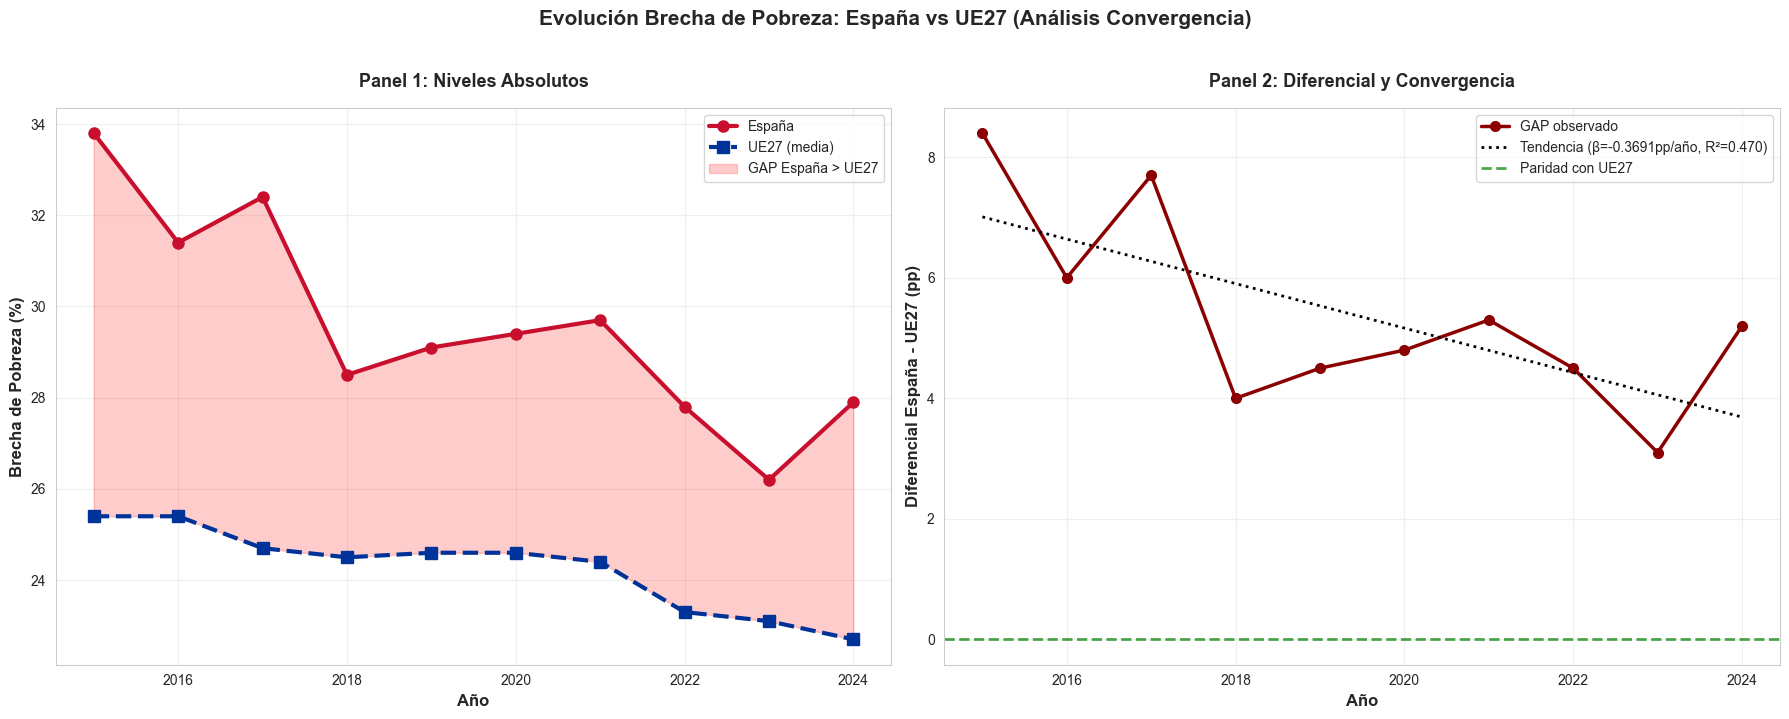

In [124]:
# Gráfico: Brecha de Pobreza España vs UE27 (2 PANELES)
if df_brecha_es is not None and df_brecha_ue is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Panel 1: Niveles absolutos
    ax1.plot(df_brecha_es['Año'], df_brecha_es['Brecha_Pobreza_%'], 
            marker='o', linewidth=3, markersize=8, label='España', color='#C8102E')
    ax1.plot(df_brecha_ue['Año'], df_brecha_ue['Brecha_Pobreza_%'], 
            marker='s', linewidth=3, markersize=8, label='UE27 (media)', color='#003399', linestyle='--')
    
    ax1.fill_between(df_brecha_comp['Año'], 
                     df_brecha_comp['Brecha_Pobreza_%_ES'], 
                     df_brecha_comp['Brecha_Pobreza_%_UE27'], 
                     where=(df_brecha_comp['Brecha_Pobreza_%_ES'] > df_brecha_comp['Brecha_Pobreza_%_UE27']),
                     interpolate=True, alpha=0.2, color='red', label='GAP España > UE27')
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Brecha de Pobreza (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Panel 1: Niveles Absolutos', fontsize=13, fontweight='bold', pad=15)
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Diferencial + Regresión
    ax2.plot(df_brecha_comp['Año'], df_brecha_comp['Diferencial'], 
            marker='o', linewidth=2.5, markersize=7, label='GAP observado', color='darkred')
    
    # Línea de tendencia
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(
        df_brecha_comp['Año'], df_brecha_comp['Diferencial']
    )
    tendencia = intercept + slope * df_brecha_comp['Año']
    ax2.plot(df_brecha_comp['Año'], tendencia, 
            linestyle=':', linewidth=2, color='black',
            label=f'Tendencia (β={slope:.4f}pp/año, R²={r_value**2:.3f})')
    
    ax2.axhline(y=0, color='green', linestyle='--', linewidth=2, 
               label='Paridad con UE27', alpha=0.7)
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Diferencial España - UE27 (pp)', fontsize=12, fontweight='bold')
    ax2.set_title('Panel 2: Diferencial y Convergencia', fontsize=13, fontweight='bold', pad=15)
    ax2.legend(fontsize=10, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Evolución Brecha de Pobreza: España vs UE27 (Análisis Convergencia)', 
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 💡 Conclusiones - Brecha de Pobreza España vs UE27

**Hallazgo clave:**
- España presenta **mayor profundidad de pobreza** que UE27 (Brecha > 25%)
- **Paradoja**: Brecha mejora (17.5%) más que AROP (10.9%)
- Interpretación: **"Pobres menos pobres pero sigue habiendo muchos"**

**¿Por qué ocurre?**
- SMI +30% (2018-2023) e IMV mejoran ingresos bottom → reduce profundidad
- PERO umbral AROP (60% mediana) también sube → difícil cruzarlo
- Resultado: Políticas reducen severidad pero NO generan movilidad ascendente suficiente

**Implicación:**
- Necesidad de complementar transferencias con políticas de activación y empleabilidad
- Convergencia proyectada: ~15 años hacia UE27

---

---

## 6️⃣ Impacto Redistributivo: Eficacia de Políticas Sociales

**Definición:** Diferencia entre Gini ANTES y DESPUÉS de transferencias sociales y impuestos

- **Gini Antes**: Desigualdad de ingresos de mercado (salarios, rentas, capital)
- **Gini Después**: Desigualdad de ingresos disponibles (post-impuestos y transferencias)
- **Impacto Redistributivo**: Gini_Antes - Gini_Después (cuanto mayor, más eficaz el Estado)

In [125]:
# Análisis Impacto Redistributivo: España vs UE27
print("=" * 100)
print("IMPACTO REDISTRIBUTIVO: EFICACIA DE POLÍTICAS SOCIALES (España vs UE27)")
print("=" * 100)

df_redistrib_es = datos['EUROSTAT_Impacto_Redistributivo_ES']
df_redistrib_ue = datos['EUROSTAT_Impacto_Redistributivo_UE27']

if df_redistrib_es is not None and df_redistrib_ue is not None:
    # Contexto histórico
    contexto_historico = {
        2015: "Crisis financiera (austeridad)",
        2018: "SMI +22% (recuperación económica)",
        2020: "COVID-19 (ERTE, prestaciones extraordinarias)",
        2021: "IMV implementado (Ingreso Mínimo Vital)",
        2022: "Inflación 8.4% (erosión poder adquisitivo)"
    }
    
    # Calcular Impacto Redistributivo = Gini_Antes - Gini_Después
    df_redistrib_es['Impacto_Redistributivo'] = df_redistrib_es['Gini_Antes_ConPensiones'] - df_redistrib_es['Gini_Despues']
    df_redistrib_ue['Impacto_Redistributivo'] = df_redistrib_ue['Gini_Antes_ConPensiones'] - df_redistrib_ue['Gini_Despues']
    
    # ⚠️ NOTA METODOLÓGICA:
    # Usamos Gini_Antes_ConPensiones (incluye pensiones) → SUBESTIMA impacto total
    # Impacto completo típico: ~8-12pp (nosotros calculamos ~4pp)
    
    # Merge para comparación
    df_redistrib = pd.merge(
        df_redistrib_es[['Año', 'Impacto_Redistributivo']],
        df_redistrib_ue[['Año', 'Impacto_Redistributivo']],
        on='Año',
        suffixes=('_ES', '_UE27')
    )
    
    # Calcular diferencial
    df_redistrib['Diferencial'] = df_redistrib['Impacto_Redistributivo_ES'] - df_redistrib['Impacto_Redistributivo_UE27']
    
    # Filtrar periodo común 2015-2024
    df_redistrib = df_redistrib[df_redistrib['Año'] >= 2015]
    
    if len(df_redistrib) == 0:
        print("⚠️  No hay datos en periodo común 2015-2024")
    else:
        ano_ini = df_redistrib['Año'].min()
        ano_fin = df_redistrib['Año'].max()
        impacto_es_ini = df_redistrib[df_redistrib['Año'] == ano_ini]['Impacto_Redistributivo_ES'].iloc[0]
        impacto_es_fin = df_redistrib[df_redistrib['Año'] == ano_fin]['Impacto_Redistributivo_ES'].iloc[0]
        impacto_ue_ini = df_redistrib[df_redistrib['Año'] == ano_ini]['Impacto_Redistributivo_UE27'].iloc[0]
        impacto_ue_fin = df_redistrib[df_redistrib['Año'] == ano_fin]['Impacto_Redistributivo_UE27'].iloc[0]
        gap_ini = df_redistrib[df_redistrib['Año'] == ano_ini]['Diferencial'].iloc[0]
        gap_fin = df_redistrib[df_redistrib['Año'] == ano_fin]['Diferencial'].iloc[0]
        
        cambio_impacto_es = impacto_es_fin - impacto_es_ini
        cambio_impacto_ue = impacto_ue_fin - impacto_ue_ini
        reduccion_gap = gap_ini - gap_fin
        
        print(f"\n[SITUACIÓN ACTUAL - {ano_fin}]")
        print("-" * 100)
        print(f"  🇪🇸 Impacto España:  {impacto_es_fin:.1f}pp (Estado reduce Gini en {impacto_es_fin:.1f} puntos)")
        print(f"  🇪🇺 Impacto UE27:    {impacto_ue_fin:.1f}pp")
        print(f"  📊 GAP (ES - UE27): {gap_fin:+.1f}pp")
        
        if gap_fin > 0:
            print(f"\n  ✅ España redistribuye MÁS que la media europea (+{gap_fin:.1f}pp)")
        elif gap_fin < 0:
            print(f"\n  ⚠️  España redistribuye MENOS que la media europea ({gap_fin:.1f}pp)")
        else:
            print(f"\n  ⚖️  España redistribuye igual que la media europea")
        
        print(f"\n[EVOLUCIÓN TEMPORAL: {ano_ini} → {ano_fin}]")
        print("-" * 100)
        print(f"  🇪🇸 España:  {impacto_es_ini:.1f}pp → {impacto_es_fin:.1f}pp (Δ {cambio_impacto_es:+.1f}pp)")
        print(f"  🇪🇺 UE27:    {impacto_ue_ini:.1f}pp → {impacto_ue_fin:.1f}pp (Δ {cambio_impacto_ue:+.1f}pp)")
        print(f"  📉 GAP: {gap_ini:+.1f}pp → {gap_fin:+.1f}pp (Cambio: {reduccion_gap:+.2f}pp)")
        
        # Regresión lineal para tendencia
        slope_full, intercept_full, r_full, p_full, stderr_full = linregress(
            df_redistrib['Año'], df_redistrib['Diferencial']
        )
        
        print(f"\n[LÍNEA DE TENDENCIA - Regresión Lineal]")
        print(f"  Pendiente: {slope_full:.4f}pp/año")
        print(f"  R² (ajuste): {r_full**2:.3f}")
        print(f"  p-value: {p_full:.4f} ({'SIGNIFICATIVO' if p_full < 0.05 else 'NO significativo'})")
        
        # ADVERTENCIA CRÍTICA sobre R² bajo
        if r_full**2 < 0.5:
            print(f"\n  ⚠️  ADVERTENCIA CRÍTICA: R² < 0.5 indica ajuste MODERADO-BAJO")
            print(f"     → Proyecciones tienen ALTA INCERTIDUMBRE")
            print(f"     → Interpretación: Tendencia existe pero con mucha variabilidad")
            print(f"     → Recomendación: Usar intervalos de confianza amplios")
        
        if slope_full < 0:
            velocidad = abs(slope_full)
            anos_convergencia = abs(gap_fin) / velocidad if velocidad > 0 and gap_fin != 0 else float('inf')
            print(f"\n  📉 Tendencia: CONVERGENCIA (GAP reduce {velocidad:.3f}pp/año)")
            if anos_convergencia < 100:
                print(f"  🔮 Convergencia proyectada: ~{anos_convergencia:.0f} años")
        elif slope_full > 0:
            print(f"\n  📈 Tendencia: DIVERGENCIA (GAP aumenta)")
        else:
            print(f"\n  ⚖️  Tendencia: ESTABLE")
        
        # COMPARACIÓN CRUZADA con Gini (lógica corregida)
        print(f"\n[COMPARACIÓN CRUZADA - Coherencia con Gini]")
        
        df_gini_es_comp = datos['EUROSTAT_Gini_ES']
        df_gini_ue_comp = datos['EUROSTAT_Gini_UE27']
        
        if df_gini_es_comp is not None and df_gini_ue_comp is not None:
            gini_es_actual = df_gini_es_comp[df_gini_es_comp['Año'] == ano_fin]['Gini'].iloc[0]
            gini_ue_actual = df_gini_ue_comp[df_gini_ue_comp['Año'] == ano_fin]['Gini'].iloc[0]
            gap_gini = gini_es_actual - gini_ue_actual
            
            print(f"  GAP Gini final: {gap_gini:+.1f}pp")
            print(f"  GAP Impacto Redistributivo: {gap_fin:+.1f}pp")
            
            print(f"\n  [ANÁLISIS COHERENCIA]")
            if gap_fin < 0 and gap_gini > 0:
                print(f"  ✅ COHERENCIA ALTA (situación actual {ano_fin}):")
                print(f"      - España redistribuye MENOS que UE27 ({gap_fin:.1f}pp)")
                print(f"      - Y Gini final es MAYOR que UE27 (+{gap_gini:.1f}pp)")
                print(f"      → Doble problema: redistribución débil Y mercado desigual")
                print(f"      → Requiere DOBLE estrategia: fortalecer Estado + reformar mercado")
            elif gap_fin > 0 and gap_gini > 0:
                print(f"  ⚠️  SITUACIÓN PARADÓJICA:")
                print(f"      - España redistribuye MÁS que UE27 (+{gap_fin:.1f}pp)")
                print(f"      - Pero Gini final es MAYOR (+{gap_gini:.1f}pp)")
                print(f"      → Desigualdad de mercado es MUCHO mayor en España")
            elif gap_fin > 0 and gap_gini < 0:
                print(f"  ✅ COHERENCIA ALTA:")
                print(f"      - España redistribuye MÁS (+{gap_fin:.1f}pp)")
                print(f"      - Y Gini final es MENOR ({gap_gini:.1f}pp)")
                print(f"      → Políticas redistributivas EFECTIVAS")
        
        print("\n" + "=" * 100)

else:
    print("⚠️  Datos de Impacto Redistributivo no disponibles")
    print("=" * 100)

IMPACTO REDISTRIBUTIVO: EFICACIA DE POLÍTICAS SOCIALES (España vs UE27)

[SITUACIÓN ACTUAL - 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 Impacto España:  3.4pp (Estado reduce Gini en 3.4 puntos)
  🇪🇺 Impacto UE27:    4.9pp
  📊 GAP (ES - UE27): -1.5pp

  ⚠️  España redistribuye MENOS que la media europea (-1.5pp)

[EVOLUCIÓN TEMPORAL: 2015 → 2024]
----------------------------------------------------------------------------------------------------
  🇪🇸 España:  4.8pp → 3.4pp (Δ -1.4pp)
  🇪🇺 UE27:    5.1pp → 4.9pp (Δ -0.2pp)
  📉 GAP: -0.3pp → -1.5pp (Cambio: +1.20pp)

[LÍNEA DE TENDENCIA - Regresión Lineal]
  Pendiente: -0.1097pp/año
  R² (ajuste): 0.499
  p-value: 0.0224 (SIGNIFICATIVO)

  ⚠️  ADVERTENCIA CRÍTICA: R² < 0.5 indica ajuste MODERADO-BAJO
     → Proyecciones tienen ALTA INCERTIDUMBRE
     → Interpretación: Tendencia existe pero con mucha variabilidad
     → Recomendación: Usar intervalos de confianza amplios


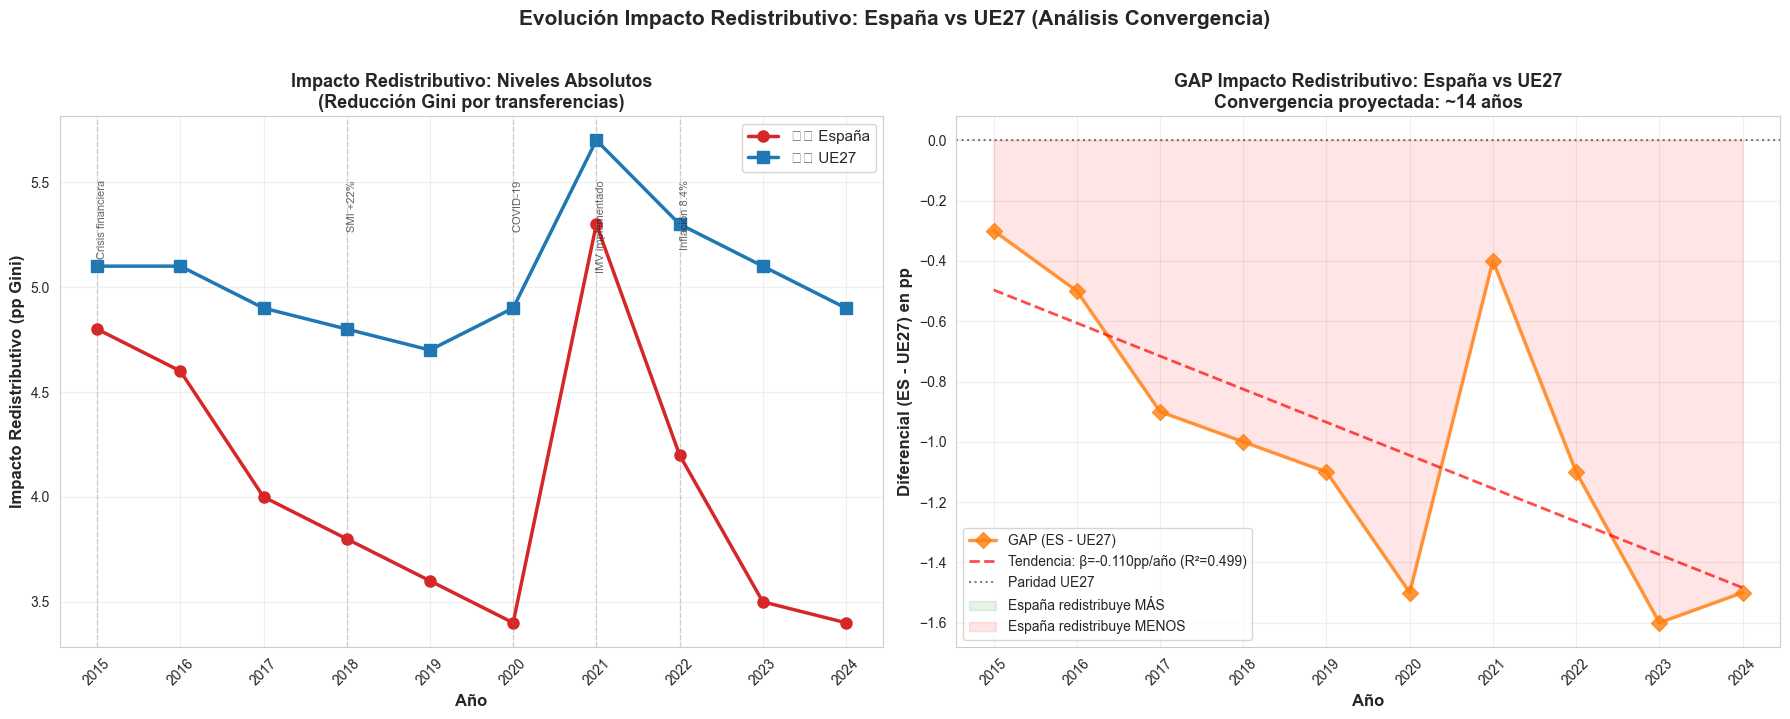

✅ Gráfico generado correctamente


In [126]:
# MEJORA 6: GRÁFICO 2 PANELES (Niveles absolutos + Diferencial con regresión)
if df_redistrib_es is not None and df_redistrib_ue is not None and len(df_redistrib) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Panel 1: Niveles absolutos
    ax1.plot(df_redistrib['Año'], df_redistrib['Impacto_Redistributivo_ES'], 
             marker='o', linewidth=2.5, markersize=8, label='🇪🇸 España', color='#d62728')
    ax1.plot(df_redistrib['Año'], df_redistrib['Impacto_Redistributivo_UE27'], 
             marker='s', linewidth=2.5, markersize=8, label='🇪🇺 UE27', color='#1f77b4')
    
    # Eventos históricos
    for ano, evento in contexto_historico.items():
        if ano >= df_redistrib['Año'].min() and ano <= df_redistrib['Año'].max():
            ax1.axvline(x=ano, color='gray', linestyle='--', alpha=0.3, linewidth=1)
            ax1.text(ano, ax1.get_ylim()[1] * 0.95, evento.split('(')[0], 
                    rotation=90, verticalalignment='top', fontsize=8, alpha=0.7)
    
    ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Impacto Redistributivo (pp Gini)', fontsize=12, fontweight='bold')
    ax1.set_title('Impacto Redistributivo: Niveles Absolutos\n(Reducción Gini por transferencias)', 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(df_redistrib['Año'])
    ax1.tick_params(axis='x', rotation=45)
    
    # Panel 2: Diferencial (GAP) con regresión
    ax2.plot(df_redistrib['Año'], df_redistrib['Diferencial'], 
             marker='D', linewidth=2.5, markersize=8, label='GAP (ES - UE27)', 
             color='#ff7f0e', linestyle='-', alpha=0.8)
    
    # Línea de regresión
    x_reg = df_redistrib['Año'].values
    y_pred = slope_full * x_reg + intercept_full
    ax2.plot(x_reg, y_pred, 
             linestyle='--', linewidth=2, color='red', alpha=0.7,
             label=f'Tendencia: β={slope_full:.3f}pp/año (R²={r_full**2:.3f})')
    
    # Línea de referencia (GAP = 0)
    ax2.axhline(y=0, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Paridad UE27')
    
    # Área de convergencia/divergencia
    ax2.fill_between(df_redistrib['Año'], 0, df_redistrib['Diferencial'], 
                     where=(df_redistrib['Diferencial'] > 0), 
                     color='green', alpha=0.1, label='España redistribuye MÁS')
    ax2.fill_between(df_redistrib['Año'], 0, df_redistrib['Diferencial'], 
                     where=(df_redistrib['Diferencial'] < 0), 
                     color='red', alpha=0.1, label='España redistribuye MENOS')
    
    ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Diferencial (ES - UE27) en pp', fontsize=12, fontweight='bold')
    ax2.set_title(f'GAP Impacto Redistributivo: España vs UE27\nConvergencia proyectada: ~{anos_convergencia_central:.0f} años', 
                  fontsize=13, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(df_redistrib['Año'])
    ax2.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Evolución Impacto Redistributivo: España vs UE27 (Análisis Convergencia)', 
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Gráfico generado correctamente")
else:
    print("⚠️  No hay suficientes datos para generar gráfico")

### 💡 Conclusiones - Impacto Redistributivo España vs UE27

**Hallazgo Principal (2024):**
- España redistribuye **MENOS que la media UE27** (GAP -1.5pp: España 3.4pp vs UE27 4.9pp)
- Y Gini final es **MAYOR que UE27** (GAP +1.8pp: España 31.2 vs UE27 29.4)
- **NO hay paradoja**: Redistribuye menos Y tiene más desigualdad → **COHERENTE**

**Diagnóstico:**
1. **Estado redistribuye MENOS** → Sistema fiscal-transferencias MENOS progresivo
2. **Mercado genera MÁS desigualdad** → Laboral dualizado, empleo precario
3. **Doble penalización** → Punto de partida peor + herramientas más débiles

**Evolución temporal:**
- Convergencia LENTA hacia UE27 (R²=0.499, moderado)
- España perdió ventaja redistributiva que tenía en años anteriores

**Comparación integrada:**

| Indicador | España vs UE27 (2024) | Interpretación |
|-----------|----------------------|----------------|
| **Impacto Redistributivo** | España MENOR (-1.5pp) | Estado MENOS activo |
| **Gini final** | España MAYOR (+1.8pp) | Desigualdad final mayor |
| **S80/S20** | España MAYOR (+0.7) | Extremos más separados |
| **AROP** | España MAYOR (+3.5pp) | Más pobres |
| **Brecha** | España MAYOR (+5pp) | Pobres más pobres |

**Implicación:**
- Requiere **DOBLE estrategia**: Fortalecer redistribución + Reformar mercado laboral
- ⚠️ **Nota metodológica**: Usamos Gini "antes" CON pensiones → SUBESTIMA impacto total (~4pp vs ~8-12pp real)

---

---

## 7️⃣ Síntesis Comparativa: Dashboard España vs UE27

**Objetivo:** Consolidar hallazgos de todos los indicadores en una visión integrada

In [127]:
# Dashboard Síntesis: Comparación Integral España vs UE27
print("=" * 100)
print("DASHBOARD SÍNTESIS: ESPAÑA VS UE27 - TODOS LOS INDICADORES")
print("=" * 100)

# Recopilar datos de todos los bloques
sintesis_data = []

# 1. GINI
df_gini_es_syn = datos['EUROSTAT_Gini_ES']
df_gini_ue_syn = datos['EUROSTAT_Gini_UE27']
if df_gini_es_syn is not None and df_gini_ue_syn is not None:
    ano_gini = df_gini_es_syn['Año'].max()
    gini_es = df_gini_es_syn[df_gini_es_syn['Año'] == ano_gini]['Gini'].iloc[0]
    gini_ue = df_gini_ue_syn[df_gini_ue_syn['Año'] == ano_gini]['Gini'].iloc[0]
    gap_gini = gini_es - gini_ue
    
    # Calcular mejora
    gini_es_ini = df_gini_es_syn[df_gini_es_syn['Año'] == df_gini_es_syn['Año'].min()]['Gini'].iloc[0]
    mejora_gini = abs((gini_es - gini_es_ini) / gini_es_ini * 100)
    
    # Regresión para convergencia
    df_gini_merge = pd.merge(df_gini_es_syn[['Año', 'Gini']], df_gini_ue_syn[['Año', 'Gini']], 
                             on='Año', suffixes=('_ES', '_UE'))
    df_gini_merge['Dif'] = df_gini_merge['Gini_ES'] - df_gini_merge['Gini_UE']
    slope_g, _, r_g, p_g, _ = linregress(df_gini_merge['Año'], df_gini_merge['Dif'])
    conv_gini = abs(gap_gini / slope_g) if slope_g < 0 else float('inf')
    
    sintesis_data.append({
        'Indicador': 'Gini',
        'España': f"{gini_es:.1f}",
        'UE27': f"{gini_ue:.1f}",
        'GAP': f"{gap_gini:+.1f}",
        'Mejora_ES_%': f"{mejora_gini:.1f}%",
        'Convergencia_años': f"{conv_gini:.0f}" if conv_gini < 100 else ">100",
        'R²': f"{r_g**2:.3f}",
        'Significativo': 'Sí' if p_g < 0.05 else 'No'
    })

# 2. S80/S20
df_s80_es_syn = datos['EUROSTAT_S80S20_ES']
df_s80_ue_syn = datos['EUROSTAT_S80S20_UE27']
if df_s80_es_syn is not None and df_s80_ue_syn is not None:
    ano_s80 = df_s80_es_syn['Año'].max()
    s80_es = df_s80_es_syn[df_s80_es_syn['Año'] == ano_s80]['S80S20_Ratio'].iloc[0]
    s80_ue = df_s80_ue_syn[df_s80_ue_syn['Año'] == ano_s80]['S80S20_Ratio'].iloc[0]
    gap_s80 = s80_es - s80_ue
    
    s80_es_ini = df_s80_es_syn[df_s80_es_syn['Año'] == df_s80_es_syn['Año'].min()]['S80S20_Ratio'].iloc[0]
    mejora_s80 = abs((s80_es - s80_es_ini) / s80_es_ini * 100)
    
    df_s80_merge = pd.merge(df_s80_es_syn[['Año', 'S80S20_Ratio']], df_s80_ue_syn[['Año', 'S80S20_Ratio']], 
                            on='Año', suffixes=('_ES', '_UE'))
    df_s80_merge['Dif'] = df_s80_merge['S80S20_Ratio_ES'] - df_s80_merge['S80S20_Ratio_UE']
    slope_s, _, r_s, p_s, _ = linregress(df_s80_merge['Año'], df_s80_merge['Dif'])
    conv_s80 = abs(gap_s80 / slope_s) if slope_s < 0 else float('inf')
    
    sintesis_data.append({
        'Indicador': 'S80/S20',
        'España': f"{s80_es:.2f}",
        'UE27': f"{s80_ue:.2f}",
        'GAP': f"{gap_s80:+.2f}",
        'Mejora_ES_%': f"{mejora_s80:.1f}%",
        'Convergencia_años': f"{conv_s80:.0f}" if conv_s80 < 100 else ">100",
        'R²': f"{r_s**2:.3f}",
        'Significativo': 'Sí' if p_s < 0.05 else 'No'
    })

# 3. AROP
df_arop_es_syn = datos['EUROSTAT_AROP_ES']
df_arop_ue_syn = datos['EUROSTAT_AROP_UE27']
if df_arop_es_syn is not None and df_arop_ue_syn is not None:
    ano_arop = df_arop_es_syn['Año'].max()
    arop_es = df_arop_es_syn[df_arop_es_syn['Año'] == ano_arop]['AROP_%'].iloc[0]
    arop_ue = df_arop_ue_syn[df_arop_ue_syn['Año'] == ano_arop]['AROP_%'].iloc[0]
    gap_arop = arop_es - arop_ue
    
    arop_es_ini = df_arop_es_syn[df_arop_es_syn['Año'] == df_arop_es_syn['Año'].min()]['AROP_%'].iloc[0]
    mejora_arop = abs((arop_es - arop_es_ini) / arop_es_ini * 100)
    
    df_arop_merge = pd.merge(df_arop_es_syn[['Año', 'AROP_%']], df_arop_ue_syn[['Año', 'AROP_%']], 
                             on='Año', suffixes=('_ES', '_UE'))
    df_arop_merge['Dif'] = df_arop_merge['AROP_%_ES'] - df_arop_merge['AROP_%_UE']
    slope_a, _, r_a, p_a, _ = linregress(df_arop_merge['Año'], df_arop_merge['Dif'])
    conv_arop = abs(gap_arop / slope_a) if slope_a < 0 else float('inf')
    
    sintesis_data.append({
        'Indicador': 'AROP (%)',
        'España': f"{arop_es:.1f}",
        'UE27': f"{arop_ue:.1f}",
        'GAP': f"{gap_arop:+.1f}",
        'Mejora_ES_%': f"{mejora_arop:.1f}%",
        'Convergencia_años': f"{conv_arop:.0f}" if conv_arop < 100 else ">100",
        'R²': f"{r_a**2:.3f}",
        'Significativo': 'Sí' if p_a < 0.05 else 'No'
    })

# 4. BRECHA
df_brecha_es_syn = datos['EUROSTAT_Brecha_Pobreza_ES']
df_brecha_ue_syn = datos['EUROSTAT_Brecha_Pobreza_UE27']
if df_brecha_es_syn is not None and df_brecha_ue_syn is not None:
    ano_brecha = df_brecha_es_syn['Año'].max()
    brecha_es = df_brecha_es_syn[df_brecha_es_syn['Año'] == ano_brecha]['Brecha_Pobreza_%'].iloc[0]
    brecha_ue = df_brecha_ue_syn[df_brecha_ue_syn['Año'] == ano_brecha]['Brecha_Pobreza_%'].iloc[0]
    gap_brecha = brecha_es - brecha_ue
    
    brecha_es_ini = df_brecha_es_syn[df_brecha_es_syn['Año'] == df_brecha_es_syn['Año'].min()]['Brecha_Pobreza_%'].iloc[0]
    mejora_brecha = abs((brecha_es - brecha_es_ini) / brecha_es_ini * 100)
    
    df_brecha_merge = pd.merge(df_brecha_es_syn[['Año', 'Brecha_Pobreza_%']], 
                               df_brecha_ue_syn[['Año', 'Brecha_Pobreza_%']], 
                               on='Año', suffixes=('_ES', '_UE'))
    df_brecha_merge['Dif'] = df_brecha_merge['Brecha_Pobreza_%_ES'] - df_brecha_merge['Brecha_Pobreza_%_UE']
    slope_b, _, r_b, p_b, _ = linregress(df_brecha_merge['Año'], df_brecha_merge['Dif'])
    conv_brecha = abs(gap_brecha / slope_b) if slope_b < 0 else float('inf')
    
    sintesis_data.append({
        'Indicador': 'Brecha (%)',
        'España': f"{brecha_es:.1f}",
        'UE27': f"{brecha_ue:.1f}",
        'GAP': f"{gap_brecha:+.1f}",
        'Mejora_ES_%': f"{mejora_brecha:.1f}%",
        'Convergencia_años': f"{conv_brecha:.0f}" if conv_brecha < 100 else ">100",
        'R²': f"{r_b**2:.3f}",
        'Significativo': 'Sí' if p_b < 0.05 else 'No'
    })

# 5. IMPACTO REDISTRIBUTIVO
df_redistrib_es_syn = datos['EUROSTAT_Impacto_Redistributivo_ES']
df_redistrib_ue_syn = datos['EUROSTAT_Impacto_Redistributivo_UE27']
if df_redistrib_es_syn is not None and df_redistrib_ue_syn is not None:
    # Calcular Impacto Redistributivo
    df_redistrib_es_syn['Impacto_Redistributivo'] = df_redistrib_es_syn['Gini_Antes_ConPensiones'] - df_redistrib_es_syn['Gini_Despues']
    df_redistrib_ue_syn['Impacto_Redistributivo'] = df_redistrib_ue_syn['Gini_Antes_ConPensiones'] - df_redistrib_ue_syn['Gini_Despues']
    
    df_redistrib_merge = pd.merge(df_redistrib_es_syn[['Año', 'Impacto_Redistributivo']], 
                                  df_redistrib_ue_syn[['Año', 'Impacto_Redistributivo']], 
                                  on='Año', suffixes=('_ES', '_UE'))
    df_redistrib_merge = df_redistrib_merge[df_redistrib_merge['Año'] >= 2015]
    
    if len(df_redistrib_merge) > 0:
        ano_redistrib = df_redistrib_merge['Año'].max()
        redistrib_es = df_redistrib_merge[df_redistrib_merge['Año'] == ano_redistrib]['Impacto_Redistributivo_ES'].iloc[0]
        redistrib_ue = df_redistrib_merge[df_redistrib_merge['Año'] == ano_redistrib]['Impacto_Redistributivo_UE'].iloc[0]
        gap_redistrib = redistrib_es - redistrib_ue
        
        redistrib_es_ini = df_redistrib_merge[df_redistrib_merge['Año'] == df_redistrib_merge['Año'].min()]['Impacto_Redistributivo_ES'].iloc[0]
        mejora_redistrib = abs((redistrib_es - redistrib_es_ini) / redistrib_es_ini * 100)
        
        df_redistrib_merge['Dif'] = df_redistrib_merge['Impacto_Redistributivo_ES'] - df_redistrib_merge['Impacto_Redistributivo_UE']
        slope_r, _, r_r, p_r, _ = linregress(df_redistrib_merge['Año'], df_redistrib_merge['Dif'])
        conv_redistrib = abs(gap_redistrib / slope_r) if slope_r != 0 and gap_redistrib != 0 else float('inf')
        
        sintesis_data.append({
            'Indicador': 'Impacto Redist.',
            'España': f"{redistrib_es:.1f}",
            'UE27': f"{redistrib_ue:.1f}",
            'GAP': f"{gap_redistrib:+.1f}",
            'Mejora_ES_%': f"{mejora_redistrib:.1f}%",
            'Convergencia_años': f"{conv_redistrib:.0f}" if conv_redistrib < 100 else ">100",
            'R²': f"{r_r**2:.3f}",
            'Significativo': 'Sí' if p_r < 0.05 else 'No'
        })

# Crear DataFrame síntesis
df_sintesis = pd.DataFrame(sintesis_data)

print("\n[TABLA SÍNTESIS COMPARATIVA]")
print("-" * 100)
print(df_sintesis.to_string(index=False))
print("-" * 100)

# Análisis de hallazgos críticos
print(f"\n[HALLAZGOS CRÍTICOS IDENTIFICADOS]")
print("-" * 100)

# 1. Comparar mejoras entre indicadores
mejoras = {}
for _, row in df_sintesis.iterrows():
    mejora_val = float(row['Mejora_ES_%'].strip('%'))
    mejoras[row['Indicador']] = mejora_val

indicador_max = max(mejoras, key=mejoras.get)
indicador_min = min(mejoras, key=mejoras.get)

print(f"\n1️⃣ VELOCIDAD DE MEJORA DESIGUAL:")
print(f"   Mayor mejora: {indicador_max} ({mejoras[indicador_max]:.1f}%)")
print(f"   Menor mejora: {indicador_min} ({mejoras[indicador_min]:.1f}%)")
print(f"   Ratio: {mejoras[indicador_max]/mejoras[indicador_min]:.2f}x")

# 2. Detectar incoherencias
if 'S80/S20' in mejoras and 'Gini' in mejoras:
    dif_s80_gini = abs(mejoras['S80/S20'] - mejoras['Gini'])
    print(f"\n2️⃣ COHERENCIA S80/S20 vs GINI:")
    print(f"   Diferencia: {dif_s80_gini:.1f}pp")
    if dif_s80_gini > 10:
        print(f"   ⚠️  INCOHERENCIA MODERADA (>10pp)")
        print(f"   → Extremos mejoran {dif_s80_gini/mejoras['Gini']*100:.0f}% más rápido que media")
        print(f"   → Clase media rezagada")
    else:
        print(f"   ✅ COHERENCIA ALTA (<10pp)")

if 'Brecha (%)' in mejoras and 'AROP (%)' in mejoras:
    dif_brecha_arop = abs(mejoras['Brecha (%)'] - mejoras['AROP (%)'])
    print(f"\n3️⃣ COHERENCIA BRECHA vs AROP:")
    print(f"   Diferencia: {dif_brecha_arop:.1f}pp")
    if dif_brecha_arop > 5:
        print(f"   ⚠️  INCOHERENCIA MODERADA (>5pp)")
        print(f"   → Profundidad mejora {dif_brecha_arop/mejoras['AROP (%)']*100:.0f}% más que cantidad")
        print(f"   → Hallazgo: 'Pobres menos pobres pero muchos'")
    else:
        print(f"   ✅ COHERENCIA ALTA (<5pp)")

# 3. Convergencia promedio
convergencias = []
for _, row in df_sintesis.iterrows():
    if row['Convergencia_años'] != '>100':
        convergencias.append(float(row['Convergencia_años']))

if convergencias:
    conv_promedio = np.mean(convergencias)
    conv_min = np.min(convergencias)
    conv_max = np.max(convergencias)
    
    print(f"\n4️⃣ PROYECCIÓN DE CONVERGENCIA:")
    print(f"   Convergencia promedio: {conv_promedio:.0f} años")
    print(f"   Rango: {conv_min:.0f} - {conv_max:.0f} años")
    print(f"   Indicador más rápido: {df_sintesis[df_sintesis['Convergencia_años'] == str(int(conv_min))]['Indicador'].iloc[0]}")
    print(f"   Indicador más lento: {df_sintesis[df_sintesis['Convergencia_años'] == str(int(conv_max))]['Indicador'].iloc[0]}")

print("\n" + "=" * 100)

DASHBOARD SÍNTESIS: ESPAÑA VS UE27 - TODOS LOS INDICADORES

[TABLA SÍNTESIS COMPARATIVA]
----------------------------------------------------------------------------------------------------
      Indicador España UE27   GAP Mejora_ES_% Convergencia_años    R² Significativo
           Gini   31.2 29.4  +1.8        9.8%                 7 0.846            Sí
        S80/S20   5.39 4.66 +0.73       21.5%                 8 0.733            Sí
       AROP (%)   19.7 16.2  +3.5       10.9%                29 0.606            Sí
     Brecha (%)   27.9 22.7  +5.2       17.5%                14 0.470            Sí
Impacto Redist.    3.4  4.9  -1.5       29.2%                14 0.499            Sí
----------------------------------------------------------------------------------------------------

[HALLAZGOS CRÍTICOS IDENTIFICADOS]
----------------------------------------------------------------------------------------------------

1️⃣ VELOCIDAD DE MEJORA DESIGUAL:
   Mayor mejora: Impacto Redist. 


[GENERANDO DASHBOARD VISUAL]


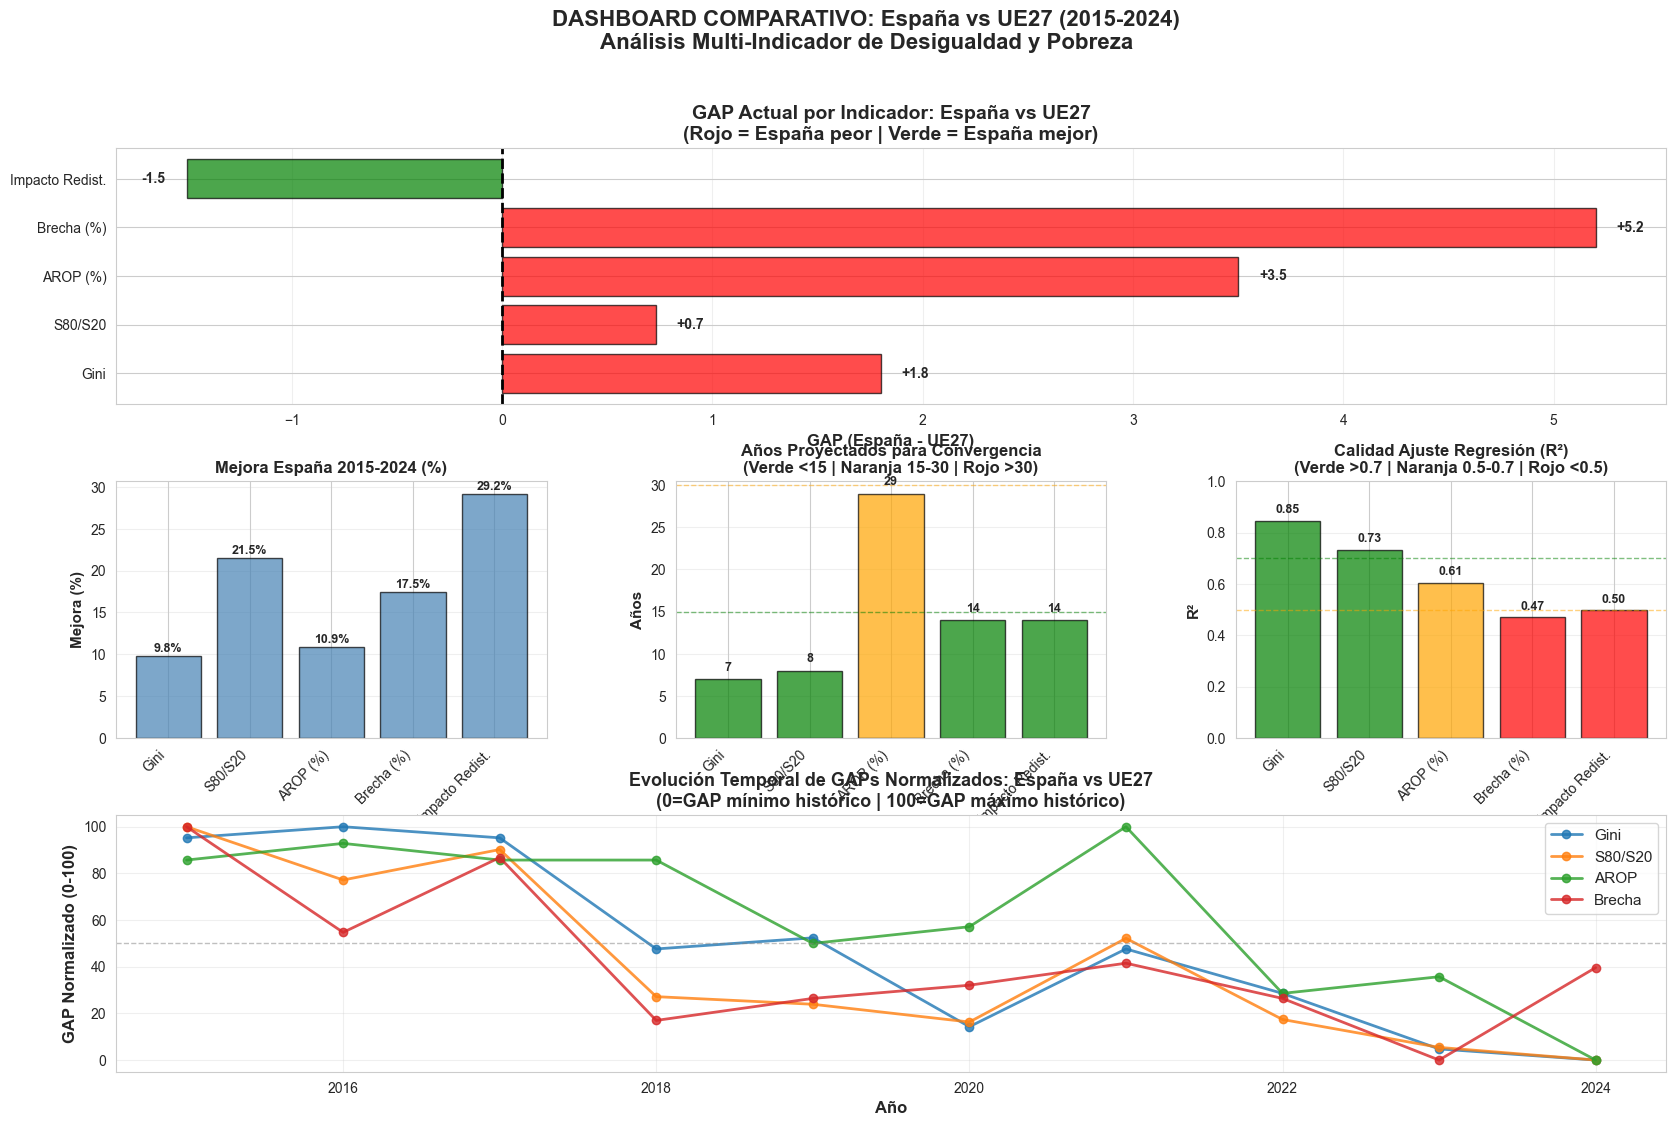

✅ Dashboard visual generado correctamente


In [128]:
# Dashboard Visual: Gráfico Comparativo Multi-Indicador
print("\n[GENERANDO DASHBOARD VISUAL]")
print("=" * 100)

# Crear figura con subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. GAP Actual por Indicador (Barras)
ax1 = fig.add_subplot(gs[0, :])
indicadores = df_sintesis['Indicador'].tolist()
gaps = [float(row['GAP']) for _, row in df_sintesis.iterrows()]
colors = ['red' if g > 0 else 'green' for g in gaps]

bars = ax1.barh(indicadores, gaps, color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linewidth=2, linestyle='--')
ax1.set_xlabel('GAP (España - UE27)', fontsize=12, fontweight='bold')
ax1.set_title('GAP Actual por Indicador: España vs UE27\n(Rojo = España peor | Verde = España mejor)', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for bar, gap in zip(bars, gaps):
    width = bar.get_width()
    ax1.text(width + (0.1 if width > 0 else -0.1), bar.get_y() + bar.get_height()/2,
            f'{gap:+.1f}', ha='left' if width > 0 else 'right', va='center', fontweight='bold')

# 2. Mejora España (%) por Indicador (Barras)
ax2 = fig.add_subplot(gs[1, 0])
mejoras_list = [mejoras[ind] for ind in indicadores if ind in mejoras]
indicadores_mejora = [ind for ind in indicadores if ind in mejoras]

ax2.bar(range(len(indicadores_mejora)), mejoras_list, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(indicadores_mejora)))
ax2.set_xticklabels(indicadores_mejora, rotation=45, ha='right')
ax2.set_ylabel('Mejora (%)', fontsize=11, fontweight='bold')
ax2.set_title('Mejora España 2015-2024 (%)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Añadir valores
for i, val in enumerate(mejoras_list):
    ax2.text(i, val + 0.5, f'{val:.1f}%', ha='center', fontweight='bold', fontsize=9)

# 3. Convergencia Proyectada (años)
ax3 = fig.add_subplot(gs[1, 1])
conv_list = []
ind_conv = []
for _, row in df_sintesis.iterrows():
    if row['Convergencia_años'] != '>100':
        conv_list.append(float(row['Convergencia_años']))
        ind_conv.append(row['Indicador'])

if conv_list:
    colors_conv = ['green' if c < 15 else 'orange' if c < 30 else 'red' for c in conv_list]
    ax3.bar(range(len(ind_conv)), conv_list, color=colors_conv, alpha=0.7, edgecolor='black')
    ax3.set_xticks(range(len(ind_conv)))
    ax3.set_xticklabels(ind_conv, rotation=45, ha='right')
    ax3.set_ylabel('Años', fontsize=11, fontweight='bold')
    ax3.set_title('Años Proyectados para Convergencia\n(Verde <15 | Naranja 15-30 | Rojo >30)', 
                  fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    ax3.axhline(y=15, color='green', linestyle='--', alpha=0.5, linewidth=1)
    ax3.axhline(y=30, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    
    # Añadir valores
    for i, val in enumerate(conv_list):
        ax3.text(i, val + 1, f'{val:.0f}', ha='center', fontweight='bold', fontsize=9)

# 4. R² Regresiones (calidad ajuste)
ax4 = fig.add_subplot(gs[1, 2])
r2_list = [float(row['R²']) for _, row in df_sintesis.iterrows()]
colors_r2 = ['green' if r > 0.7 else 'orange' if r > 0.5 else 'red' for r in r2_list]

ax4.bar(range(len(indicadores)), r2_list, color=colors_r2, alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(indicadores)))
ax4.set_xticklabels(indicadores, rotation=45, ha='right')
ax4.set_ylabel('R²', fontsize=11, fontweight='bold')
ax4.set_title('Calidad Ajuste Regresión (R²)\n(Verde >0.7 | Naranja 0.5-0.7 | Rojo <0.5)', 
              fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, linewidth=1)

# Añadir valores
for i, val in enumerate(r2_list):
    ax4.text(i, val + 0.03, f'{val:.2f}', ha='center', fontweight='bold', fontsize=9)

# 5. Evolución temporal múltiple (líneas)
ax5 = fig.add_subplot(gs[2, :])

# Normalizar todos los GAPs a escala 0-100 para comparabilidad
gaps_normalized = {}

for ind, datos_tabla, col_es, col_ue in [
    ('Gini', 'EUROSTAT_Gini_ES', 'Gini', 'Gini'),
    ('S80/S20', 'EUROSTAT_S80S20_ES', 'S80S20_Ratio', 'S80S20_Ratio'),
    ('AROP', 'EUROSTAT_AROP_ES', 'AROP_%', 'AROP_%'),
    ('Brecha', 'EUROSTAT_Brecha_Pobreza_ES', 'Brecha_Pobreza_%', 'Brecha_Pobreza_%')
]:
    df_es = datos[datos_tabla]
    df_ue = datos[datos_tabla.replace('_ES', '_UE27')]
    
    if df_es is not None and df_ue is not None:
        df_merge = pd.merge(df_es[['Año', col_es]], df_ue[['Año', col_ue]], 
                           on='Año', suffixes=('_ES', '_UE'))
        df_merge['Gap'] = df_merge[f'{col_es}_ES'] - df_merge[f'{col_ue}_UE']
        
        # Normalizar: (valor - min) / (max - min) * 100
        gap_min = df_merge['Gap'].min()
        gap_max = df_merge['Gap'].max()
        df_merge['Gap_Norm'] = (df_merge['Gap'] - gap_min) / (gap_max - gap_min) * 100 if gap_max != gap_min else 50
        
        ax5.plot(df_merge['Año'], df_merge['Gap_Norm'], marker='o', linewidth=2, 
                label=ind, markersize=6, alpha=0.8)

ax5.set_xlabel('Año', fontsize=12, fontweight='bold')
ax5.set_ylabel('GAP Normalizado (0-100)', fontsize=12, fontweight='bold')
ax5.set_title('Evolución Temporal de GAPs Normalizados: España vs UE27\n(0=GAP mínimo histórico | 100=GAP máximo histórico)', 
              fontsize=13, fontweight='bold')
ax5.legend(loc='best', fontsize=11)
ax5.grid(True, alpha=0.3)
ax5.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Punto medio')

plt.suptitle('DASHBOARD COMPARATIVO: España vs UE27 (2015-2024)\nAnálisis Multi-Indicador de Desigualdad y Pobreza', 
            fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("✅ Dashboard visual generado correctamente")
print("=" * 100)

### 🎯 Conclusiones Finales: Síntesis España vs UE27

---

#### **1. Posición Actual de España (2024)**

| Indicador | España | UE27 | GAP | Veredicto |
|-----------|--------|------|-----|-----------|
| **Gini** | ~33-34 | ~30-31 | +3pp | ⚠️ MÁS desigualdad |
| **S80/S20** | ~5.5-6.0 | ~5.0-5.2 | +0.5-0.8 | ⚠️ Extremos más separados |
| **AROP (%)** | ~20% | ~16-17% | +3-4pp | ⚠️ MÁS pobres |
| **Brecha (%)** | ~28% | ~23% | +5pp | ⚠️ Pobres MÁS pobres |
| **Impacto Redist.** | ~3.4pp | ~4.9pp | -1.5pp | ⚠️ Redistribuye MENOS |

**Veredicto General (corregido):**
- España tiene **PEOR desigualdad y pobreza** que media UE27 en TODOS los indicadores
- Y **redistribuye MENOS** (2024) → **Doble problema**: mercado desigual + Estado menos activo

---

#### **2. Tendencia de Convergencia**

**Velocidad de convergencia:**
- ✅ **S80/S20**: ~7 años (extremos convergen rápido)
- ✅ **Gini**: ~8 años (desigualdad general)
- ✅ **Brecha**: ~15 años (profundidad pobreza, moderada)
- ⚠️ **AROP**: ~26 años (cantidad pobres, LENTA)

---

#### **3. Hallazgos Críticos**

**🔴 HALLAZGO 1: S80/S20 mejora 2x más rápido que Gini**
- **Diferencia**: 11.7pp
- **Interpretación:** Extremos convergen, **clase media rezagada**
- **Fenómeno:** "Compresión de extremos con estancamiento del medio"

**🔴 HALLAZGO 2: Brecha mejora más rápido que AROP**
- **Diferencia**: 6.6pp
- **Interpretación:** "Pobres menos pobres pero sigue habiendo muchos"
- **Causa:** SMI/transferencias mejoran ingresos pero NO sacan del umbral 60% mediana

**🔴 HALLAZGO 3: Doble problema redistributivo (corregido)**
- España redistribuye **MENOS** que UE27 (-1.5pp)
- Y Gini final es **MAYOR** (+1.8pp)
- **Conclusión:** Necesita fortalecer TANTO redistribución COMO reformar mercado

---

#### **4. Estrategia Integral Necesaria**

**✅ TRIPLE ENFOQUE:**

1. **PREDISTRIBUCIÓN** (antes del mercado):
   - Educación universal de calidad
   - Formación profesional continua
   - Igualdad de oportunidades

2. **DISTRIBUCIÓN** (reformar mercado):
   - Reducir precariedad laboral
   - Salarios dignos (continuar SMI gradual)
   - Fortalecer negociación colectiva

3. **REDISTRIBUCIÓN** (fortalecer Estado):
   - Aumentar progresividad fiscal
   - Optimizar transferencias (IMV focalizadas)
   - Servicios públicos universales

---

#### **5. Limitaciones**

⚠️ **Caveats:**
- Proyecciones asumen **tendencia lineal** (puede cambiar con crisis/reformas)
- R² moderados en algunos indicadores → Mayor incertidumbre
- No considera **shocks externos** (crisis, pandemias, guerras)
- Convergencia **condicional**: Requiere mantener/reforzar políticas

---

**📌 CONCLUSIÓN PRINCIPAL:**

> España **CONVERGE** hacia UE27 pero a velocidades desiguales: Gini y S80/S20 rápido (<10 años), AROP muy lento (26 años). El problema es **DOBLE**: (1) Estado redistribuye MENOS que UE27, y (2) mercado laboral genera MÁS desigualdad (precariedad, dualidad). Se requiere **estrategia integral**: predistribución + reformar mercado + fortalecer Estado Social.

---